# ONLY plotting spatial correlation - data is already saved as .nc files
In this script, the spatial correlation is plotted. The data will not be touched in any way, as it is already saved as a .nc file, from the "Spatial and auto correlation on corrected model output.ipynb" Notebook.

In [1]:
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import xarray as xr
import atlite
import logging
import cdsapi
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
from cartopy.io import shapereader
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd

import pgeocode      
import seaborn as sns         

import scipy.sparse as sp
from collections import OrderedDict
%matplotlib inline
import requests
import os
os.environ['ESGF_PYCLIENT_NO_FACETS_STAR_WARNING']='1'
import zipfile

from matplotlib.gridspec import GridSpec
from atlite.gis import shape_availability, ExclusionContainer
# from rasterio.plot import show
import rasterio

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import datetime
import glob

from sklearn.metrics import mean_squared_error
import math
from pathlib import Path

# Defining figure size for maps:
map_fig_size = (10,10)

In [2]:
from countrygroups import EUROPEAN_UNION

# Adding non-EU countries to the list of countries
#others = (["Switzerland","Czech Republic", "Ukraine","Moldova", "Serbia","Albania", "United Kingdom", 
#           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
others = (["Switzerland","Czech Republic", "Serbia","Albania", "United Kingdom", 
           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
europe_list = EUROPEAN_UNION.names + others
europe_list.remove("Czechia")
europe_list.sort()
# print(europe_list)

c:\Users\Theag\anaconda3\envs\clone_environment_atlite\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


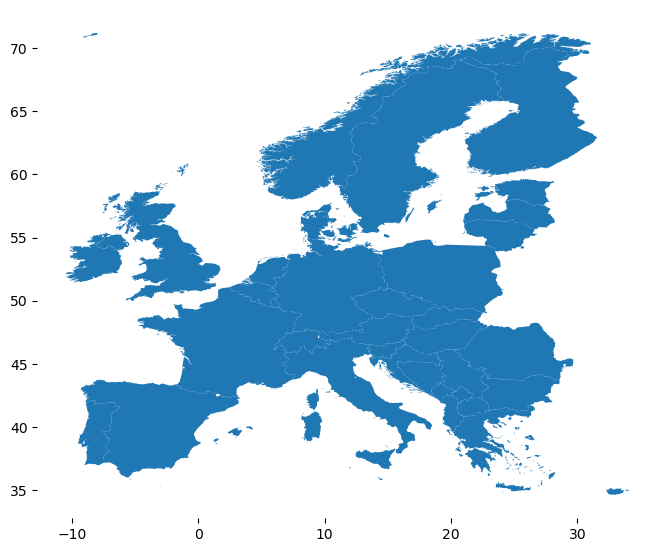

In [3]:
# Defining shape of European countries

shpfilename = shapereader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shapereader.Reader(shpfilename)
Europe = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
#).reindex(["Austria","Denmark","Germany","Italy"])
).reindex(europe_list)

# Removing extra territories (islands in the Atlantic, etc.)
mask = (-11, 30, 50, 74)
Europe = Europe.clip(mask)
Europe.plot(figsize=(8,8),aspect='equal').set_frame_on(False)

In [4]:
bounds = Europe.unary_union.buffer(1).bounds
model_colors = pd.read_excel("model_colors.xlsx",header=0,index_col=0)

### Defining cutouts etc.

In [5]:
# All CMIP6 models: 
CMIP6_models = ['EC-Earth3', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR','HadGEM3-GC31-MM', 'HadGEM3-GC31-LL', 'AWI-CM-1-1-MR','IPSL-CM6A-LR','EC-Earth3-Veg','ACCESS-CM2']
CMIP6_models_wind = ['EC-Earth3','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','EC-Earth3-Veg'] #wind
CMIP6_models_solar = ['EC-Earth3', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR','HadGEM3-GC31-MM','HadGEM3-GC31-LL','AWI-CM-1-1-MR','IPSL-CM6A-LR','ACCESS-CM2']
ssp_variants = ['ssp585']

In [6]:
# Importing/creating  CMIP6 cutouts from external HDD
# Models with all 4 ssp variants:
CMIP6_models = ['EC-Earth3', 'MPI-ESM1-2-HR', 'MIROC6', 'MPI-ESM1-2-LR','MPI-ESM1-2-HR','HadGEM3-GC31-LL','HadGEM3-GC31-MM','ACCESS_CM2','AWI-CM-1-1-MR','EC-Earth3-Veg','IPSL-CM6A-LR']
ssp_variants = ['ssp585']

date_format = "%Y-%m-%d"
# Define cutout time duration: 
# start_date = "2070-01-01"
# end_date = "2099-12-31"
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        cutout_name = f'Europe_{i}_{j}_{yy_start}_{yy_end}'
        print(cutout_name)
        filename = f'Europe_{i}_{j}_{yy_start}_{yy_end}.nc'
        path = f"E://Master's/CMIP6_EOC/{filename}"
        locals()[cutout_name] = atlite.Cutout(
        path=path, module="cmip", bounds=bounds, time=slice(start_date, end_date),
        dt='3H',dx=1, dy=1)

Europe_EC_Earth3_ssp585_15_22
Europe_MPI_ESM1_2_HR_ssp585_15_22
Europe_MIROC6_ssp585_15_22
Europe_MPI_ESM1_2_LR_ssp585_15_22
Europe_MPI_ESM1_2_HR_ssp585_15_22
Europe_HadGEM3_GC31_LL_ssp585_15_22
Europe_HadGEM3_GC31_MM_ssp585_15_22
Europe_ACCESS_CM2_ssp585_15_22
Europe_AWI_CM_1_1_MR_ssp585_15_22
Europe_EC_Earth3_Veg_ssp585_15_22
Europe_IPSL_CM6A_LR_ssp585_15_22


### Plotting the map with locations for reference grid points

<bound method Figure.tight_layout of <Figure size 800x800 with 1 Axes>>

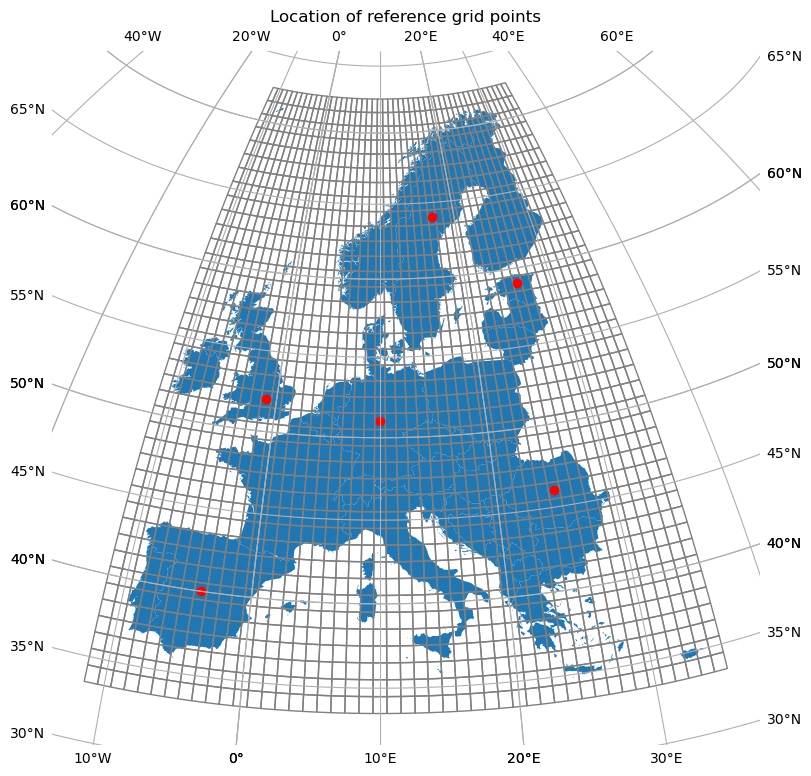

In [7]:
import matplotlib.ticker as mticker

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

# grid_coords = [3,56] 
# fig, ax = plt.subplots(figsize=(8,8))
# Europe.plot(ax=ax)
projection = ccrs.Orthographic(10, 35)
fig, ax = plt.subplots(figsize=(8,8),subplot_kw={"projection": projection}, layout='constrained')
Europe.plot(ax=ax,transform=plate(),aspect='equal').set_frame_on(False)
ax.set_title('Location of reference grid points')
Europe_EC_Earth3_ssp585_15_22.grid.plot(ax=ax,edgecolor='grey',color='None',transform=plate(),aspect='equal')
ax.plot(10,51,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.plot(-4,40,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.plot(17,64,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.plot(-1,52,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.plot(25,46,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.plot(26,59,marker="o",markersize=6,markerfacecolor="red",markeredgecolor="red",alpha=1,transform=plate())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False)
gl.top_labels = False
gl.xlocator = mticker.FixedLocator([-20,-10,-0,0,10,20,30])
gl.ylocator = mticker.FixedLocator([35,40,45,50,55,60,65,70,75,80])
gl.xformatter = LongitudeFormatter()
fig.tight_layout
# filepath = 'Plots_autocorrelation/'f'grid_x{grid_coords[0]}_y{grid_coords[1]}.png'
# plt.savefig(filepath)

# Retrieving the data from .nc files
Have all the values in the "Corrected wnd90m for CMIP6 models", "Corrected influx for CMIP6 models" and the era5

In [8]:
########## WIND ################# 
CMIP6_models = CMIP6_models_wind
ssp_variants = ['ssp585']
variable = 'wnd90m'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MIROC6_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Co

### Retrieving BOC wnd90m for EC-Earth3 with method 3

In [9]:
variablename = f'Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix'
savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\BOC\{variablename}.nc"
print(f'"{variablename}" retrieved from path: {savedpath}')
locals()[variablename] = xr.open_dataset(savedpath)
locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\BOC\Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix.nc


In [10]:
########## SOLAR ################# 
CMIP6_models = CMIP6_models_solar
ssp_variants = ['ssp585']
variable = 'influx'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2015-01-01"
end_date = "2022-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected influx for CMIP6 models\BOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_EC_Earth3_ssp585_15_22_influx.nc
"Corrected_Europe_MIROC6_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MIROC6_ssp585_15_22_influx.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_influx.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_15_22_influx.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_15_22_influx.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_15_22_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\BOC\Co

In [11]:
########## WIND EOC ################# 
CMIP6_models = CMIP6_models_wind
ssp_variants = ['ssp585']
variable = 'wnd90m'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2070-01-01"
end_date = "2099-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected wnd90m for CMIP6 models\EOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MIROC6_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_wnd90m.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_wnd90m" retrieved from path: E:\Master's\Corrected wnd90m for CMIP6 models\EOC\Co

In [12]:
########## SOLAR ################# - NB ALL THESE VALUES ARE TESTED, THEY ARE CORRECTLY CORRECTED - THEA 2/12
CMIP6_models = CMIP6_models_solar
ssp_variants = ['ssp585']
variable = 'influx'

date_format = "%Y-%m-%d"
# Define cutout time duration: 
start_date = "2070-01-01"
end_date = "2099-12-31"

yy_start = datetime.datetime.strptime(start_date,"%Y-%m-%d").year-2000
yy_end = datetime.datetime.strptime(end_date,"%Y-%m-%d").year-2000

for i in CMIP6_models:
    i = i.replace("-", "_")     # Replacing - with _ for all CMIP6 model names
    for j in ssp_variants:
        variablename = f'Corrected_Europe_{i}_{j}_{yy_start}_{yy_end}_{variable}'
        savedpath = f"E:\\Master's\Corrected influx for CMIP6 models\EOC\{variablename}.nc"
        print(f'"{variablename}" retrieved from path: {savedpath}')
        locals()[variablename] = xr.open_dataset(savedpath)
        locals()[variablename] = locals()[variablename]["__xarray_dataarray_variable__"].load()

"Corrected_Europe_EC_Earth3_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_EC_Earth3_ssp585_70_99_influx.nc
"Corrected_Europe_MIROC6_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MIROC6_ssp585_70_99_influx.nc
"Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_influx.nc
"Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_MPI_ESM1_2_LR_ssp585_70_99_influx.nc
"Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Corrected_Europe_HadGEM3_GC31_MM_ssp585_70_99_influx.nc
"Corrected_Europe_HadGEM3_GC31_LL_ssp585_70_99_influx" retrieved from path: E:\Master's\Corrected influx for CMIP6 models\EOC\Co

In [13]:
### LOADING ERA5 INFLUX AT 3hourly VALUES 
savedpath = f"E:\\Master's\ERA5\influx\Europe_era5_15_22_influx_3hr_correct.nc"
Europe_era5_15_22_influx_3hr = xr.open_dataset(savedpath)
Europe_era5_15_22_influx_3hr =Europe_era5_15_22_influx_3hr["__xarray_dataarray_variable__"].load()

In [14]:
### corrected (by GWA) era5 for europe - at 90m, 3hr and coarse resolution 
savedpath = f"E:\\Master's\ERA5\wnd90m\Europe_era5_15_22_wnd90m_3hr_corrected.nc"
Europe_era5_15_22_wnd90m_3hr_corrected = xr.open_dataarray(savedpath)
Europe_era5_15_22_wnd90m_3hr_corrected = Europe_era5_15_22_wnd90m_3hr_corrected.load()

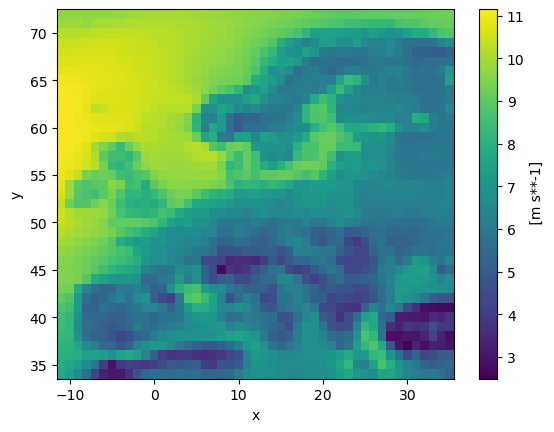

In [15]:
Europe_era5_15_22_wnd90m_3hr_corrected.mean(dim=["time"],keep_attrs=True).plot()

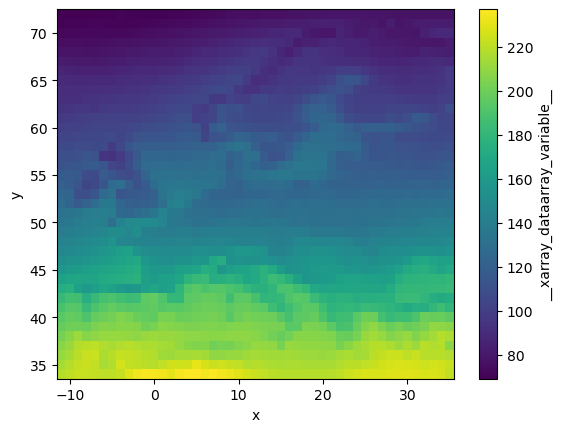

In [16]:
Europe_era5_15_22_influx_3hr.mean(dim=["time"],keep_attrs=True).plot()

# SPATIAL CORRELATION FUNCTION
The function for doing spatial correlation is defined here

In [17]:
def spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs,saveplot=None,make_plot=True):
    if np.any(data.isnull())==True: 
        # data = data.where(data.isnull()==False,0.0)
        data = data.dropna(dim="x",how="all").dropna(dim="y",how="all")
    
    if grid_coords[0] == 17: country = 'Sweden'
    if grid_coords[0] == 26: country = 'Estonia'
    if grid_coords[0] == -1: country = 'England'
    if grid_coords[0] == 10: country = 'Germany'
    if grid_coords[0] == 25: country = 'Romania'
    if grid_coords[0] == -4: country = 'Spain'
    
    # cell_coords = [grid_coords[1] - data[0,0,0].y.values,grid_coords[0] - data[0,0,0].x.values]
    cell_coords = [int(grid_coords[1] - data[0,0,0].y.values),int(grid_coords[0] - data[0,0,0].x.values)]
        
    if CMIP6_model == 'MPI_ESM1_2_HR' and variable =='wnd90m':
        cell1 = data[cell_coords[0],cell_coords[1],:]
        range_i = range(data.shape[0])
        range_j = range(data.shape[1])
        corr_coeffs = xr.zeros_like(data[:,:,1])
        dist = xr.zeros_like(data[:,:,1])
    else: 
        cell1 = data[:,cell_coords[0],cell_coords[1]]
        range_i = range(data.shape[1])
        range_j = range(data.shape[2])
        corr_coeffs = xr.zeros_like(data[1,:,:])
        dist = xr.zeros_like(data[1,:,:])
 
    for i in range_i:
        # for j in range(data.shape[2]):
        for j in range_j:
            if CMIP6_model == 'MPI_ESM1_2_HR' and variable =='wnd90m': 
                cell2 = data[i,j,:]
            else: 
                cell2 = data[:,i,j]
            
            corr = xr.corr(cell1,cell2,dim="time").values
            corr_coeffs[i,j] = corr
            dist[i,j] = np.sqrt(np.square(cell_coords[0]-i)+np.square(cell_coords[1]-j))*dx

    # dis = np.sort(dist.to_numpy().flatten())
    dis = dist.to_numpy().flatten()
    cor_theo = xr.DataArray(coords=(range(len(CLs)),range(len(dis))))
    i=0
    RMSE=[]
    for CL in CLs: 
        cor_theo[i] = [np.exp(-(1/CL)*d) for d in dis]
        if np.any(cor_theo[i].isnull())==True: print('cor theo isnull') 
        MSE = mean_squared_error(corr_coeffs.to_numpy().flatten(),cor_theo[i])
        # MSE = mean_squared_error(np.sort(corr_coeffs.to_numpy().flatten()),cor_theo[i])
        RMSE.append(round(math.sqrt(MSE),7))
        i = i+1

    # saving the min values and sorting them for a more practical output:
    min_RMSE_index = RMSE.index(min(RMSE))
    cor_theo = cor_theo[min_RMSE_index].sortby(cor_theo[min_RMSE_index],ascending=False).values
    dis = np.sort(dis)

    if variable == "influx": 
        plotcolor = 'gold'
        title = f"Spatial correlation for influx, 20{yy_start}-20{yy_end} \n in reference point [{grid_coords[0]},{grid_coords[1]}] in {country}"
    else: 
        plotcolor = '#1f77b4'
        title = f"Spatial correlation for wind speed at 90 m, 20{yy_start}-20{yy_end} \n in reference point [{grid_coords[0]},{grid_coords[1]}] in {country}"

    if make_plot ==True:
        plt.scatter(dist,corr_coeffs,s = 2,color=plotcolor,alpha=0.6)
        plt.plot(dis,cor_theo,'black',linewidth=2)
        plt.xlabel('Distance [km]')
        plt.ylabel("Pearson's correlation coefficient")
        # plt.title(f"Spatial correlation, 20{yy_start}-20{yy_end} \n from gridpoint [{grid_coords[0]},{grid_coords[1]}]")
        plt.title(title)
        plt.legend([f'{CMIP6_model.replace("_","-")}',f'Exponential fit, CL = {CLs[min_RMSE_index]} km, RMSE = {round(RMSE[min_RMSE_index],3)}'])
        plt.tight_layout
    
    if saveplot != None:
        filepath = 'Plots_spatial_correlation/'f'Spatial_correlation_{CMIP6_model}_{ssp_variant}_grid_x{grid_coords[0]}_y{grid_coords[1]}'
        plt.savefig(filepath)
        print('Plot saved to',filepath)
        
    return CLs[min_RMSE_index], RMSE[min_RMSE_index], cor_theo,dis #cor_theo[min_RMSE_index]

# Spatial correlation result plots - For a single model
This calculates the correlation - is unnecessary, as everything for the reference locations is already saved as .nc files. But, if it is wanted to investigate spatial correlation in other places than the specified reference locations, it can be done here. 

## BOC

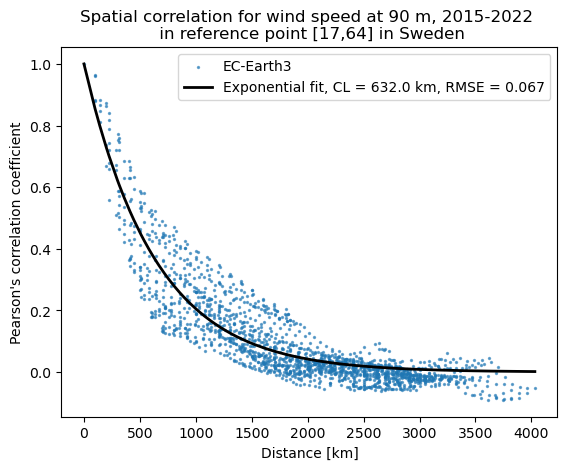

In [18]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 15
yy_end = 22
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]

if variable =="wnd90m":
    CLs = np.linspace(100,2000,1901)    #wind
else: 
    CLs = np.linspace(1000,20000,19001)           #solar


CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

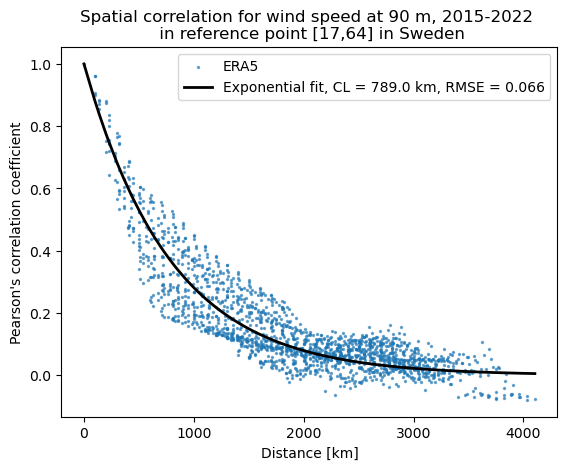

In [89]:
### INPUTS ####
CMIP6_model = 'ERA5'
yy_start = 15
yy_end = 22
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]

if variable =="wnd90m":
    CLs = np.linspace(100,2000,1901)    #wind
else: 
    CLs = np.linspace(1000,20000,19001)           #solar


CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
# data = locals()[f'{cutout_name}_{variable}']
data = Europe_era5_15_22_wnd90m_3hr_corrected

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

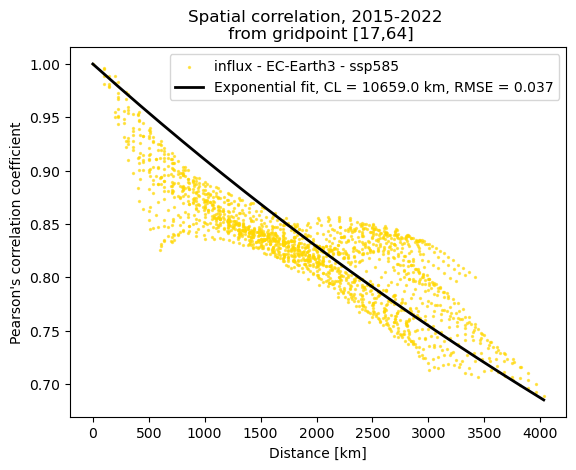

In [21]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 15
yy_end = 22
variable = "influx"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [-4,40]
# CLs = np.linspace(100,2000,1901)    #wind
CLs = np.linspace(1000,15000,14001)           #solar

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

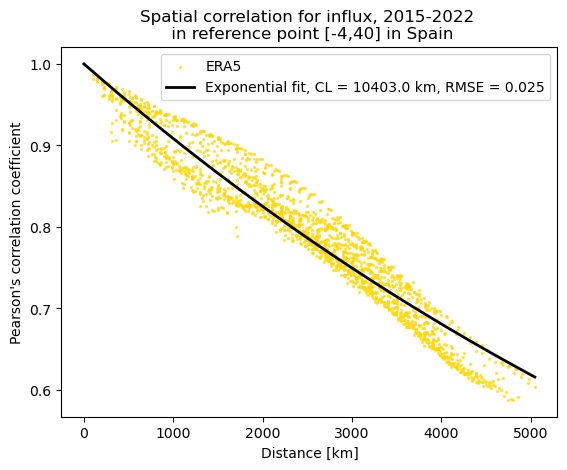

In [90]:
### INPUTS ####
CMIP6_model = 'ERA5'
yy_start = 15
yy_end = 22
variable = "influx"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [-4,40]
# CLs = np.linspace(100,2000,1901)    #wind
CLs = np.linspace(1000,15000,14001)           #solar

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = Europe_era5_15_22_influx_3hr ## UNCORRECTED ERA 5, 3HR DATA, COARSE GRID


CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs) 

## EOC

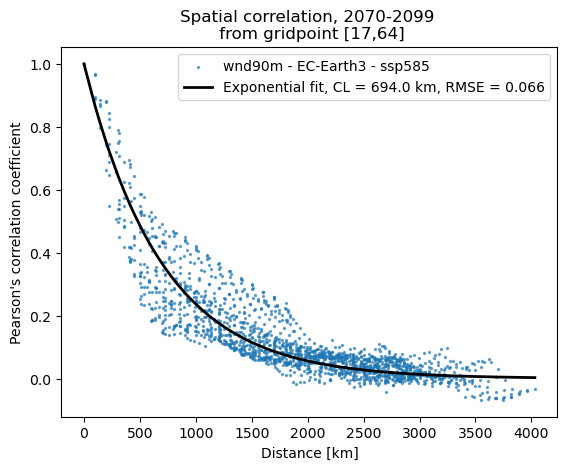

In [19]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 70
yy_end = 99
variable = "wnd90m"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]

if variable =="wnd90m":
    CLs = np.linspace(100,2000,1901)    #wind
else: 
    CLs = np.linspace(1000,20000,19001)           #solar


CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

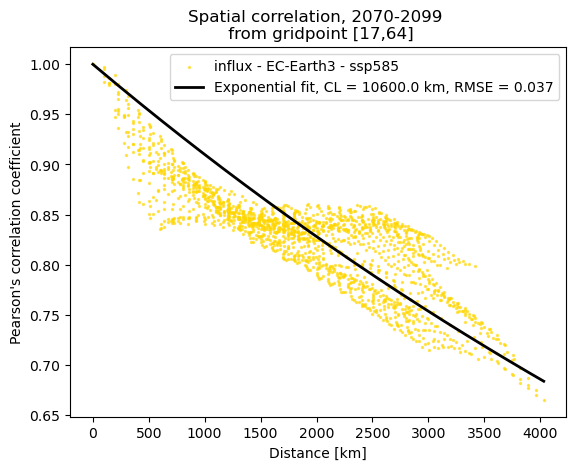

In [20]:
### INPUTS ####
CMIP6_model = 'EC-Earth3'
yy_start = 70
yy_end = 99
variable = "influx"
ssp_variant = 'ssp585'
dx = 100        #[km] Nominal resolution of model / cutout
grid_coords = [17,64]
# CLs = np.linspace(100,2000,1901)    #wind
CLs = np.linspace(1000,15000,14001)           #solar

CMIP6_model = CMIP6_model.replace("-","_")
cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
data = locals()[f'{cutout_name}_{variable}']

CL, RMSE,cor_theo,dis =spatial_correlation(data,CMIP6_model,ssp_variant,dx,yy_start,yy_end,variable,grid_coords,CLs)

# Plotting CL's for all models in one location
Only for places where the analysis has already been run and the values are saved as .nc files. 
This uses the files from the "Spatial Correlation for corrected CMIP6 models" folder. 

## BOC

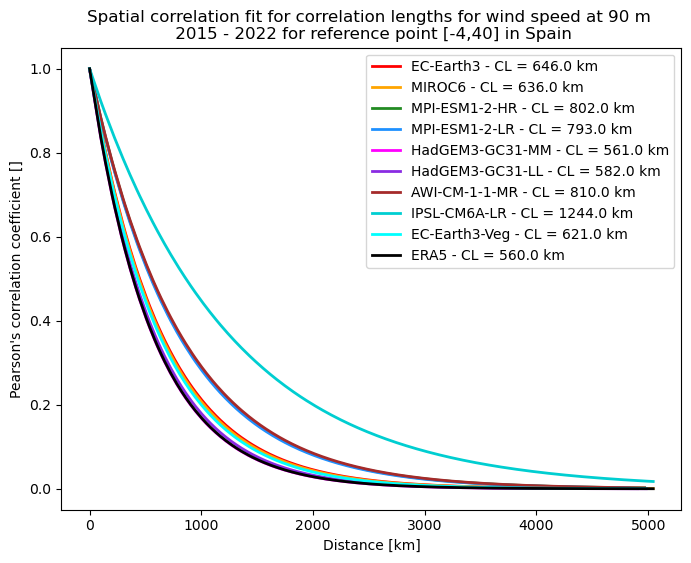

In [19]:
### Plotting the theoretical CL's and ACFs
grid_coords = [-4,40]
variable = "wnd90m"
# variable = "influx"

if grid_coords[0] == 17: country = 'Sweden'
if grid_coords[0] == 26: country = 'Estonia'
if grid_coords[0] == -1: country = 'England'
if grid_coords[0] == 10: country = 'Germany'
if grid_coords[0] == 25: country = 'Romania'
if grid_coords[0] == -4: country = 'Spain'

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    title = f"Spatial correlation fit for correlation lengths for wind speed at 90 m \n 20{yy_start} - 20{yy_end} for reference point [{grid_coords[0]},{grid_coords[1]}] in {country}"
else: 
    CMIP6_models = CMIP6_models_solar
    title = f"Spatial correlation fit for correlation lengths for influx \n 20{yy_start} - 20{yy_end} for reference point [{grid_coords[0]},{grid_coords[1]}] in {country}"

ssp_variant = 'ssp585'
yy_start = 15
yy_end = 22
dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

path_CL_RMSE = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_{variable}_{grid_info}.nc"

CL_RMSE = xr.open_dataset(path_CL_RMSE)

fig,ax = plt.subplots(figsize=(8,6))
legend = []
i = 0
path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\"
for model in CL_RMSE.index.values:
    plotcolor = model_colors.loc[model]['Color']
    # plot_linestyle = model_colors.loc[model]['Linestyle']
    plot_linestyle = '-'
    CL = CL_RMSE["CL"].loc[model].values
    if model == "era5":
        legend.append(f"ERA5 - CL = {CL} km")
    else:
        legend.append(f"{model} - CL = {CL} km")# 
    
    model = model.replace("-","_")
    path_cor_theo = f"{path}\cor_theo\cor_theo_{variable}_{model}_{grid_info}.nc"
    path_dis = f"{path}\dis\dis_{variable}_{model}_{grid_info}.nc"
    cor_theo_plot = xr.open_dataset(path_cor_theo)
    dis_plot = xr.open_dataset(path_dis)
    if model == "era5":
        ax.plot(dis_plot["dis_era5"].values,cor_theo_plot["cor_theo_era5"].values,plot_linestyle,c=plotcolor,linewidth = 2)
    else: 
        ax.plot(dis_plot["dis"].values,cor_theo_plot["cor_theo"].values,plot_linestyle,c=plotcolor,linewidth = 2)
    
ax.set_title(title)
ax.set_xlabel('Distance [km]')
ax.set_ylabel("Pearson's correlation coefficient []")
ax.legend(legend)

In [64]:
# Save the plot above?
# filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Spatial correlation\Spatial correlation BOC corrected\CL_{variable}_graph_{grid_info}.png"
filepath = f"E://Master's/Spatial Correlation for corrected CMIP6 models/BOC/Plots/CL_{variable}_graph_{grid_info}.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

"E://Master's/Spatial Correlation for corrected CMIP6 models/BOC/Plots/CL_wnd90m_graph_xneg4_y40.png"

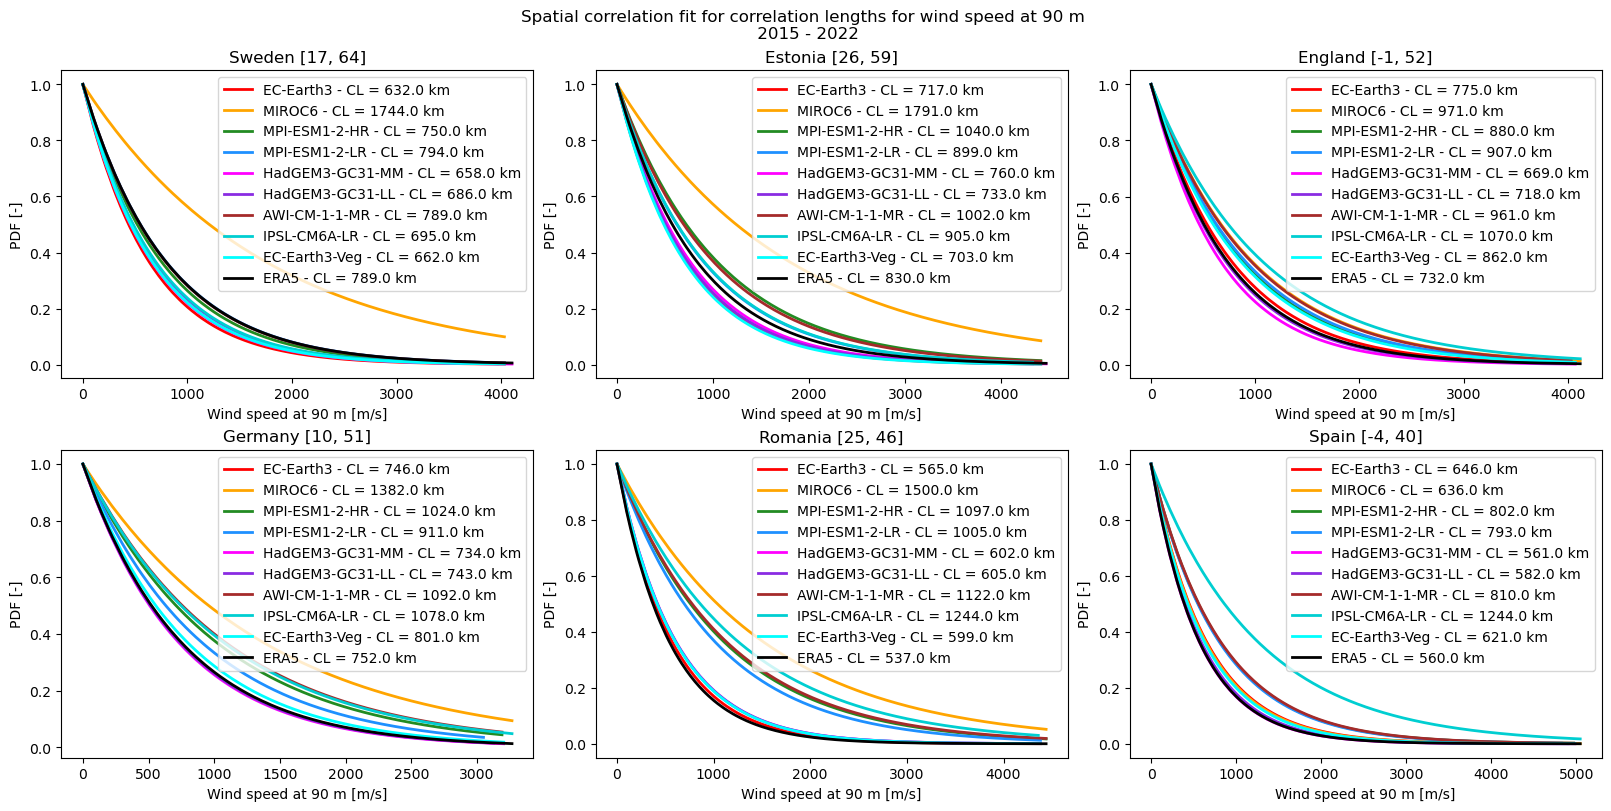

In [20]:
### WND90M ########
variable = "wnd90m"
CMIP6_models = CMIP6_models_wind
bins = 30

point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

legend_mod = False;
ssp_variant = 'ssp585'
fig,axs = plt.subplots(2,3,figsize=(16,8),layout='constrained')
title =  f"Spatial correlation fit for correlation lengths for wind speed at 90 m \n 20{yy_start} - 20{yy_end}"
fig.suptitle(title)

for ii in range(6):
    legend = []
    point_name = f'point_{ii+1}';
    point = locals()[point_name];
    country_name = ref_country[ii]
    # CMIP6_model =CMIP6_model.replace('-','_')
    #############################
    
    if point[0] < 0: 
        grid_info = f"xneg{abs(point[0])}_y{point[1]}"
    else:
        grid_info = f"x{point[0]}_y{point[1]}"

    path_CL_RMSE = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_{variable}_{grid_info}.nc"

    CL_RMSE = xr.open_dataset(path_CL_RMSE)

    legend = []
    path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\\"
    for model in CL_RMSE.index.values:
        plotcolor = model_colors.loc[model]['Color']
        plot_linestyle = '-'
        CL = CL_RMSE["CL"].loc[model].values
        
        if model == "era5":
            legend.append(f"ERA5 - CL = {CL} km")
        else:
            legend.append(f"{model} - CL = {CL} km")# 
        
        model = model.replace("-","_")
        path_cor_theo = f"{path}\cor_theo\cor_theo_{variable}_{model}_{grid_info}.nc"
        path_dis = f"{path}\dis\dis_{variable}_{model}_{grid_info}.nc"
        cor_theo_plot = xr.open_dataset(path_cor_theo)
        dis_plot = xr.open_dataset(path_dis)
        if model == "era5":
            axs.flat[ii].plot(dis_plot["dis_era5"].values,cor_theo_plot["cor_theo_era5"].values,plot_linestyle,c=plotcolor,linewidth = 2)
        else: 
            axs.flat[ii].plot(dis_plot["dis"].values,cor_theo_plot["cor_theo"].values,plot_linestyle,c=plotcolor,linewidth = 2)
            
    
    ############################ 
    axs.flat[ii].legend(legend)
    axs.flat[ii].set_ylabel('PDF [-]')
    axs.flat[ii].set(xlabel='Wind speed at 90 m [m/s]')
    axs.flat[ii].set_title(f'{country_name} [{point[0]}, {point[1]}]')

# fig.legend([f"{CMIP6_model.replace('_','-')} BOC",f"{CMIP6_model.replace('_','-')} EOC"],ncols=2,loc='outside lower center')
# fig.legend(legend,ncols=4,loc='outside lower center')

## EOC

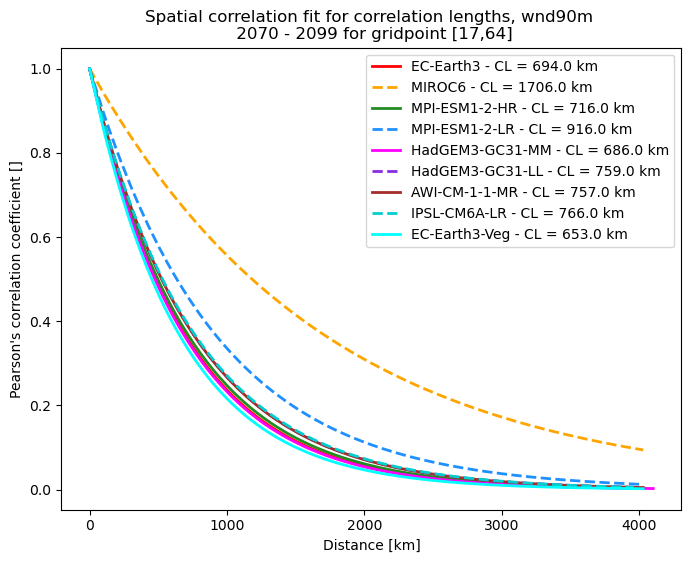

In [21]:
### Plotting the theoretical CL's and ACFs
grid_coords = [17,64]
variable = "wnd90m"
# variable = "influx"

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
else: 
    CMIP6_models = CMIP6_models_solar

ssp_variant = 'ssp585'
yy_start = 70
yy_end = 99
dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

path_CL_RMSE = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\EOC\CL_RMSE\CL_RMSE_{variable}_{grid_info}_EOC.nc"

CL_RMSE = xr.open_dataset(path_CL_RMSE)

fig,ax = plt.subplots(figsize=(8,6))
legend = []
i = 0
path = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\EOC\\"
for model in CL_RMSE.index.values:
    plotcolor = model_colors.loc[model]['Color']
    plot_linestyle = model_colors.loc[model]['Linestyle']
    CL = CL_RMSE["CL"].loc[model].values
    if model == "era5":
        legend.append(f"ERA5 - CL = {CL} km")
    else:
        legend.append(f"{model} - CL = {CL} km")# 
    
    model = model.replace("-","_")
    path_cor_theo = f"{path}\cor_theo\cor_theo_{variable}_{model}_{grid_info}_EOC.nc"
    path_dis = f"{path}\dis\dis_{variable}_{model}_{grid_info}_EOC.nc"
    cor_theo_plot = xr.open_dataset(path_cor_theo)
    dis_plot = xr.open_dataset(path_dis)
    if model == "era5":
        ax.plot(dis_plot["dis_era5"].values,cor_theo_plot["cor_theo_era5"].values,plot_linestyle,c=plotcolor,linewidth = 2)
    else: 
        ax.plot(dis_plot["dis"].values,cor_theo_plot["cor_theo"].values,plot_linestyle,c=plotcolor,linewidth = 2)
    
ax.set_title(f"Spatial correlation fit for correlation lengths, {variable} \n 20{yy_start} - 20{yy_end} for gridpoint [{grid_coords[0]},{grid_coords[1]}]")
ax.set_xlabel('Distance [km]')
ax.set_ylabel("Pearson's correlation coefficient []")
ax.legend(legend)

# CORRELATION LENGTH PRECISION VS SPATIAL RESOLUTION OF MODELS

In [23]:
### Table pd.dataframe with model names, nominal resolution, longitudinal and lateral resolution
model_resolutions = pd.read_excel("model_resolutions.xlsx",header=0,index_col=0)
# grid_infos = ['[17,64]','[26,59]','[-1,52]','[10,51]','[25,46]','[-4,40]']
grid_infos = ['x17_y64','x26_y59','xneg1_y52','x10_y51','x25_y46','xneg4_y40']

# DataFrame to store percent difference for CL from each model at each point to the ERA5 value
CL_difference_wind = pd.DataFrame(np.zeros([len(CMIP6_models_wind),len(grid_infos)]),index=CMIP6_models_wind,columns=grid_infos)
CL_difference_solar = pd.DataFrame(np.zeros([len(CMIP6_models_solar),len(grid_infos)]),index=CMIP6_models_solar,columns=grid_infos)

###### NEXT LINE IS ONLY FOR SEEING HOW TO FIND VALUES IN THE RESOLUTIONS TABLE
model_resolutions.loc['EC-Earth3']['Nominal resolution']

100.0

In [24]:
## Calculating the percent difference in each point for each model and storing in the CL_difference_{variable} tables
### diff = (CMIP6-ERA5)/ERA5 so that it is positive if CMIP6 is bigger ###

#### WIND ##### - NEEDS TO BE RECALCULATED WITH NEW ERA5 VALUES
for grid_info in grid_infos:
    path_CL_RMSE = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_wnd90m_{grid_info}.nc"
    CL_RMSE = xr.open_dataset(path_CL_RMSE)
    CL_era5 = CL_RMSE["CL"].loc["era5"].values
    for model in CMIP6_models_wind:
        CL_CMIP = CL_RMSE["CL"].loc[model].values
        diff = ((CL_CMIP-CL_era5)/CL_era5)*100
        CL_difference_wind[grid_info][model] = diff

#### SOLAR #####
for grid_info in grid_infos:
    path_CL_RMSE = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_influx_{grid_info}.nc"
    CL_RMSE = xr.open_dataset(path_CL_RMSE)
    CL_era5 = CL_RMSE["CL"].loc["era5"].values
    if CL_era5.shape == (2,):       
        CL_era5 = CL_era5[0]
        print('shape2') 

    for model in CMIP6_models_solar:
        CL_CMIP = CL_RMSE["CL"].loc[model].values
        diff = ((CL_CMIP-CL_era5)/CL_era5)*100
        CL_difference_solar[grid_info][model] = diff

In [25]:
from matplotlib.lines import Line2D  
legend_elements_wind = [Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[0],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[0]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[1],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[1]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[2],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[2]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[3],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[3]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[4],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[4]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[5],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[5]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[6],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[6]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[7],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[7]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[8],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[8]]['Color'], markersize=7)]

legend_elements_solar = [Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[0],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[0]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[1],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[1]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[2],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[2]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[3],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[3]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[4],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[4]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[5],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[5]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[6],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[6]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[7],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[7]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_solar[8],
                          markerfacecolor=model_colors.loc[CMIP6_models_solar[8]]['Color'], markersize=7)]

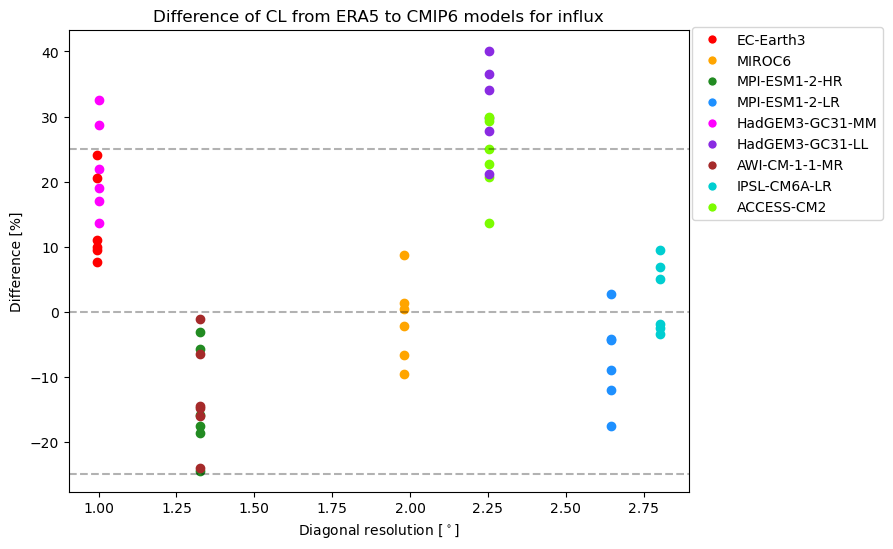

In [26]:
#### solar #####
# res_type = "Longitudinal resolution"        #Type of resolution to investigate - choose between "Diagonal resolution", "Longitudinal resolution","Lateral resolution" and "Nominal resolution"
res_type = "Diagonal resolution"
# res_type = "Lateral resolution"
# res_type = "Conservative resolution"            #Largest of lat or lon

fig,ax = plt.subplots(figsize=(8,6))
legendname = []

for grid_info in grid_infos:
    for model in CMIP6_models_solar:
        plotcolor = model_colors.loc[model]['Color']
        diff = CL_difference_solar[grid_info][model]
        res = model_resolutions[res_type][model]
        ax.plot(res,diff,'o',c=plotcolor)

ax.set_title(f"Difference of CL from ERA5 to CMIP6 models for influx")
ax.set_xlabel(f"{res_type} $[^\circ]$")
ax.set_ylabel("Difference [%]")
ax.legend(handles = legend_elements_solar,bbox_to_anchor=(1.325,1.02))
ax.axhline(y=0,color='black',linestyle='--',alpha=0.3)
ax.axhline(y=-25,color='black',linestyle='--',alpha=0.3)
ax.axhline(y=25,color='black',linestyle='--',alpha=0.3)

# ax.set_ylim([-75,75])
# ax.set_yticks(np.linspace(-25,225,11))

In [88]:
# Save the plot above?
filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Spatial correlation\Spatial correlation BOC corrected\diff_vs_res_influx_{res_type.replace(' ','_')}_corrected.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight') 
# filepath

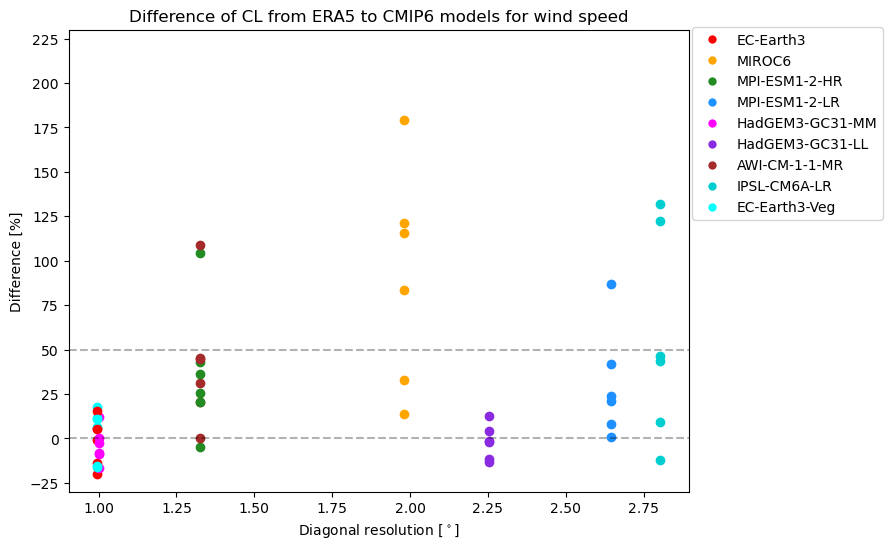

In [27]:
#### WIND #####
# res_type = "Longitudinal resolution"        #Type of resolution to investigate - choose between "Diagonal resolution", "Longitudinal resolution","Lateral resolution" and "Nominal resolution"
res_type = "Diagonal resolution"
# res_type = "Lateral resolution"
# res_type = "Conservative resolution"            #Largest of lat or lon

fig,ax = plt.subplots(figsize=(8,6))
legendname = []

for grid_info in grid_infos:
    for model in CMIP6_models_wind:
        plotcolor = model_colors.loc[model]['Color']
        diff = CL_difference_wind[grid_info][model]
        res = model_resolutions[res_type][model]
        ax.plot(res,diff,'o',c=plotcolor)

ax.set_title(f"Difference of CL from ERA5 to CMIP6 models for wind speed")
ax.set_xlabel(f"{res_type} $[^\circ]$")
ax.set_ylabel("Difference [%]")
# ax.legend(handles = legend_elements_wind,bbox_to_anchor=(1.01,1.02))
ax.legend(handles = legend_elements_wind,bbox_to_anchor=(1.325,1.02))
ax.set_ylim([-30,230])
ax.axhline(y=0,color='black',linestyle='--',alpha=0.3)
ax.axhline(y=50,color='black',linestyle='--',alpha=0.3)
ax.set_yticks(np.linspace(-25,225,11))

In [70]:
# Save the plot above?
filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Spatial correlation\Spatial correlation BOC corrected\diff_vs_res_wnd90m_{res_type.replace(' ','_')}_corrected.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight') 
# filepath

## Spatial correlation BOC vs EOC
If wind, will not use MIROC6 

##### Wind

In [28]:
from matplotlib.lines import Line2D  

legend_elements_wind_no_MIROC6 = [Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[0],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[0]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[2],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[2]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[3],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[3]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[4],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[4]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[5],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[5]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[6],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[6]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[7],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[7]]['Color'], markersize=7),
                       Line2D([0], [0], marker='o', color='w', label=CMIP6_models_wind[8],
                          markerfacecolor=model_colors.loc[CMIP6_models_wind[8]]['Color'], markersize=7)]

In [29]:
## Calculating the difference in each point for each model and storing in the CL_difference_{variable} tables
### diff = EOC - BOC so that it is positive if EOC is bigger ###
### percent_diff = (EOC-BOC)/BOC so that it is positive if EOC is bigger
grid_infos = ['x17_y64','x26_y59','xneg1_y52','x10_y51','x25_y46','xneg4_y40']

wnd90m_CL_change_BOC_to_EOC = pd.DataFrame(np.zeros([len(CMIP6_models_wind),len(grid_infos)]),index=CMIP6_models_wind,columns=grid_infos)
wnd90m_CL_percent_diff_BOC_to_EOC = pd.DataFrame(np.zeros([len(CMIP6_models_wind),len(grid_infos)]),index=CMIP6_models_wind,columns=grid_infos)

#### WIND ##### - NEEDS TO BE RECALCULATED WITH NEW ERA5 VALUES
for grid_info in grid_infos:
    path_CL_RMSE_BOC = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_wnd90m_{grid_info}.nc"
    CL_RMSE_BOC = xr.open_dataset(path_CL_RMSE_BOC)
   
    path_CL_RMSE_EOC = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\EOC\CL_RMSE\CL_RMSE_wnd90m_{grid_info}_EOC.nc"
    CL_RMSE_EOC = xr.open_dataset(path_CL_RMSE_EOC)
    
    for model in CMIP6_models_wind:
        # print(model)
        CL_BOC = CL_RMSE_BOC["CL"].loc[model].values
        CL_EOC = CL_RMSE_EOC["CL"].loc[model].values
        diff = CL_EOC - CL_BOC
        percent_diff = (diff/CL_BOC)*100
        wnd90m_CL_change_BOC_to_EOC[grid_info][model] = diff
        wnd90m_CL_percent_diff_BOC_to_EOC[grid_info][model] = percent_diff

### DROPPING MIROC6 ####
wnd90m_CL_percent_diff_BOC_to_EOC = wnd90m_CL_percent_diff_BOC_to_EOC.drop(index='MIROC6')

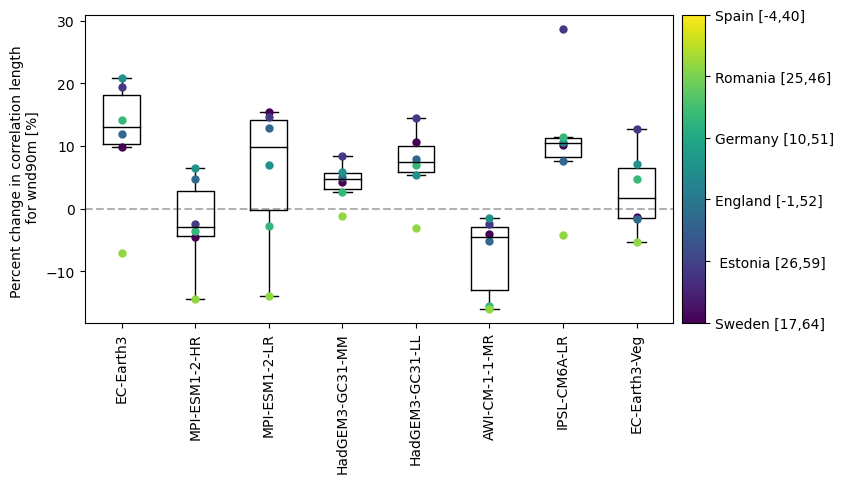

In [31]:
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import seaborn as sb

#### WND90M ####


#%%
plt.figure(figsize=(8, 4))
gs1 = gridspec.GridSpec(1, 20)
gs1.update(wspace=0.4, hspace=0.2)
ax1 = plt.subplot(gs1[0,0:19])
ax2 = plt.subplot(gs1[0,19])

ax1.boxplot(wnd90m_CL_percent_diff_BOC_to_EOC.transpose()[wnd90m_CL_percent_diff_BOC_to_EOC.index], showfliers=False, medianprops=dict(color='black'))
ax1.set_ylabel('Percent change in correlation length \n for wnd90m [%]')
ax1.set_xticks(np.arange(1,len(wnd90m_CL_percent_diff_BOC_to_EOC.index)+1),wnd90m_CL_percent_diff_BOC_to_EOC.index, rotation=90)
cmap = matplotlib.colormaps.get_cmap('viridis')

for i,grid_info in enumerate(grid_infos):
    ax1.plot(np.arange(1,len(wnd90m_CL_percent_diff_BOC_to_EOC.index)+1), wnd90m_CL_percent_diff_BOC_to_EOC[grid_info], linewidth=0,
             marker='o', markersize=5, color=cmap(i/len(grid_infos)))
    cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap)
    ax2.set_yticks(np.arange(0,1.1,1/(len(grid_infos)-1)))
    ax2.set_yticklabels(['Sweden [17,64]',' Estonia [26,59]','England [-1,52]','Germany [10,51]','Romania [25,46]','Spain [-4,40]'])
ax1.axhline(y=0,color='black',linestyle='--',alpha=0.3)

filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\EOC\Spatial correlation\percent_diff_wnd90m_boxplot_cmip6model_axis.png"
# plt.savefig(filepath,dpi=300,bbox_inches='tight') 

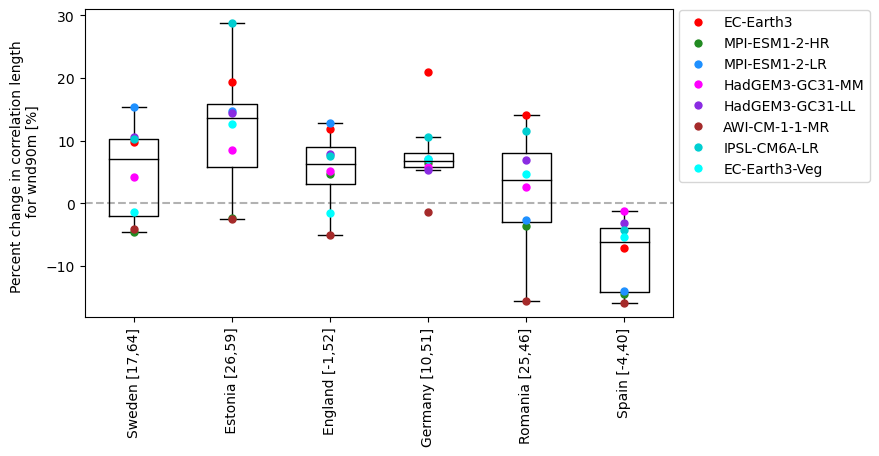

In [32]:
#%%
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(gs1[0,0:19])

ax1.boxplot(wnd90m_CL_percent_diff_BOC_to_EOC[grid_infos], showfliers=False, medianprops=dict(color='black'))
ax1.set_ylabel('Percent change in correlation length \n for wnd90m [%]')
ax1.set_xticks(np.arange(1,len(grid_infos)+1),['Sweden [17,64]',' Estonia [26,59]','England [-1,52]','Germany [10,51]','Romania [25,46]','Spain [-4,40]'], rotation=90)

for i,CMIP6_model in enumerate(wnd90m_CL_percent_diff_BOC_to_EOC.index):
    ax1.plot(np.arange(1,len(grid_infos)+1), wnd90m_CL_percent_diff_BOC_to_EOC.loc[CMIP6_model], linewidth=0,
             marker='o', markersize=5, color= model_colors.loc[CMIP6_model]['Color'])
    cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap)
ax1.axhline(y=0,color='black',linestyle='--',alpha=0.3)
ax1.legend(handles = legend_elements_wind_no_MIROC6,bbox_to_anchor=(1.345,1.02))

filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\EOC\Spatial correlation\percent_diff_wnd90m_boxplot_location_axis.png"
# plt.savefig(filepath,dpi=300,bbox_inches='tight') 

## Solar

In [33]:
## Calculating the difference in each point for each model and storing in the CL_difference_{variable} tables
### diff = EOC - BOC so that it is positive if EOC is bigger ###
### percent_diff = (EOC-BOC)/BOC so that it is positive if EOC is bigger
influx_CL_change_BOC_to_EOC = pd.DataFrame(np.zeros([len(CMIP6_models_solar),len(grid_infos)]),index=CMIP6_models_solar,columns=grid_infos)
influx_CL_percent_diff_BOC_to_EOC = pd.DataFrame(np.zeros([len(CMIP6_models_solar),len(grid_infos)]),index=CMIP6_models_solar,columns=grid_infos)

#### WIND ##### - NEEDS TO BE RECALCULATED WITH NEW ERA5 VALUES
for grid_info in grid_infos:
    path_CL_RMSE_BOC = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\BOC\CL_RMSE\CL_RMSE_influx_{grid_info}.nc"
    CL_RMSE_BOC = xr.open_dataset(path_CL_RMSE_BOC)
   
    path_CL_RMSE_EOC = f"E:\Master's\Spatial Correlation for corrected CMIP6 models\EOC\CL_RMSE\CL_RMSE_influx_{grid_info}_EOC.nc"
    CL_RMSE_EOC = xr.open_dataset(path_CL_RMSE_EOC)
    
    for model in CMIP6_models_solar:
        CL_BOC = CL_RMSE_BOC["CL"].loc[model].values
        CL_EOC = CL_RMSE_EOC["CL"].loc[model].values
        diff = CL_EOC - CL_BOC
        percent_diff = (diff/CL_BOC)*100
        influx_CL_change_BOC_to_EOC[grid_info][model] = diff
        influx_CL_percent_diff_BOC_to_EOC[grid_info][model] = percent_diff

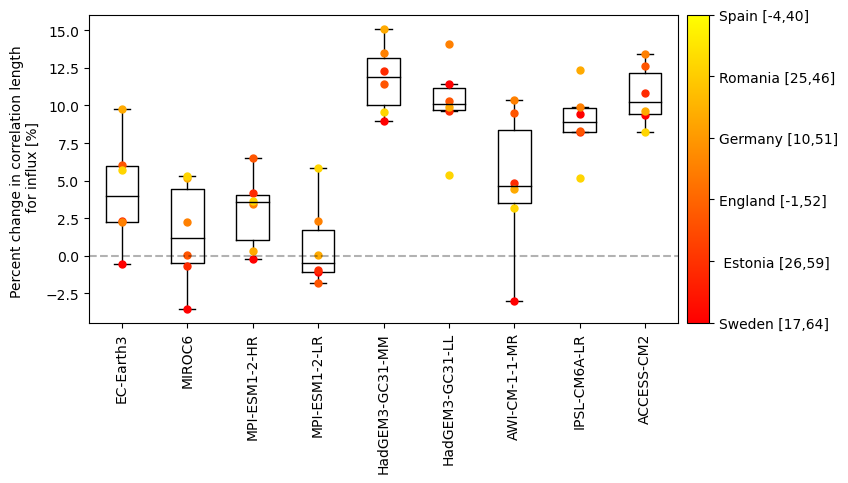

In [34]:
#### INFLUX ####

plt.figure(figsize=(8, 4))
gs1 = gridspec.GridSpec(1, 20)
gs1.update(wspace=0.4, hspace=0.2)
ax1 = plt.subplot(gs1[0,0:19])
ax2 = plt.subplot(gs1[0,19])

ax1.boxplot(influx_CL_percent_diff_BOC_to_EOC.transpose()[influx_CL_percent_diff_BOC_to_EOC.index], showfliers=False, medianprops=dict(color='black'))
ax1.set_ylabel('Percent change in correlation length \n for influx [%]')
ax1.set_xticks(np.arange(1,len(influx_CL_percent_diff_BOC_to_EOC.index)+1),influx_CL_percent_diff_BOC_to_EOC.index, rotation=90)
cmap = matplotlib.colormaps.get_cmap('autumn')

for i,grid_info in enumerate(grid_infos):
    ax1.plot(np.arange(1,len(influx_CL_percent_diff_BOC_to_EOC.index)+1), influx_CL_percent_diff_BOC_to_EOC[grid_info], linewidth=0,
             marker='o', markersize=5, color=cmap(i/len(grid_infos)))
    cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap)
    ax2.set_yticks(np.arange(0,1.1,1/(len(grid_infos)-1)))
    ax2.set_yticklabels(['Sweden [17,64]',' Estonia [26,59]','England [-1,52]','Germany [10,51]','Romania [25,46]','Spain [-4,40]'])
ax1.axhline(y=0,color='black',linestyle='--',alpha=0.3)


filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\EOC\Spatial correlation\percent_diff_influx_boxplot_cmip6model_axis.png"
plt.savefig(filepath,dpi=300,bbox_inches='tight') 

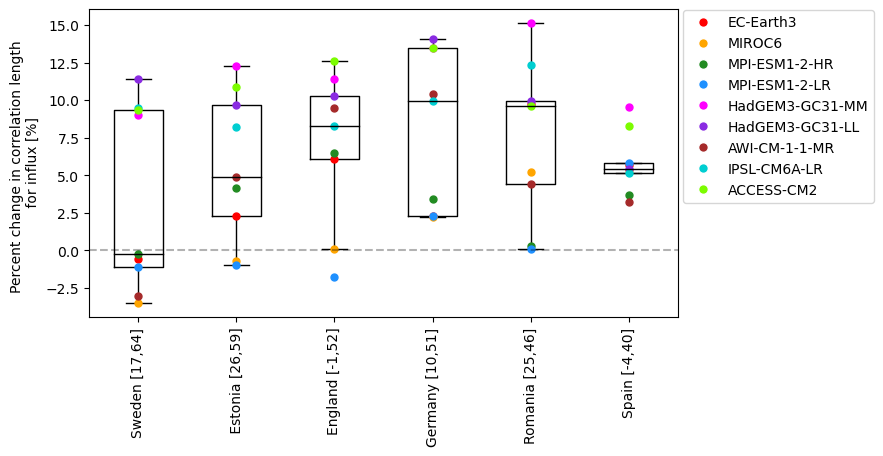

In [68]:
#%%
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(gs1[0,0:19])

ax1.boxplot(influx_CL_percent_diff_BOC_to_EOC[grid_infos], showfliers=False, medianprops=dict(color='black'))
ax1.set_ylabel('Percent change in correlation length \n for influx [%]')
ax1.set_xticks(np.arange(1,len(grid_infos)+1),['Sweden [17,64]',' Estonia [26,59]','England [-1,52]','Germany [10,51]','Romania [25,46]','Spain [-4,40]'], rotation=90)

for i,CMIP6_model in enumerate(influx_CL_percent_diff_BOC_to_EOC.index):
    ax1.plot(np.arange(1,len(grid_infos)+1), influx_CL_percent_diff_BOC_to_EOC.loc[CMIP6_model], linewidth=0,
             marker='o', markersize=5, color= model_colors.loc[CMIP6_model]['Color'])
    cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap)

ax1.axhline(y=0,color='black',linestyle='--',alpha=0.3)
ax1.legend(handles = legend_elements_solar,bbox_to_anchor=(1.345,1.02))

filepath = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\EOC\Spatial correlation\percent_diff_influx_boxplot_location_axis.png"
# plt.savefig(filepath,dpi=300,bbox_inches='tight') 

# AUTOCORRELATION

Here, the temporal correlation analysis is conducted. 

In [35]:
def autocorrelation(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05,figname=None,era5=None,plot_map = None):
    
    if grid_coords[0] > globals()[data[0]][0,-1,-1].x.values or grid_coords[1] > globals()[data[0]][0,-1,-1].y.values:
        print('Grid coords not in cutout')
        
    elif grid_coords[0] < globals()[data[0]][0,0,0].x.values or grid_coords[1] < globals()[data[0]][0,0,0].y.values:
        print('Grid coords are not in cutout!')
        data = []       #Lazy way to make function fail. Sorry. 
    
    #Converting grid_coords to cell_coords
    cell_coords = [grid_coords[1] - globals()[data[0]][0,0,0].y.values, grid_coords[0] - globals()[data[0]][0,0,0].x.values]
    fig,ax = plt.subplots()
    nlags = round(lags/3)        #Number of lags from hourly to 3-hourly values
    legendlist = []
    
    for i in range(len(data)):
        data_i = data[i]
        
        legendlist.append(CMIP6_models[i])
        plotcolor = model_colors.loc[CMIP6_models[i]]['Color']

        if data_i == 'Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m' or data_i == 'Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m' or data_i == 'Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix': 
            data_i = globals()[data_i][cell_coords[0],cell_coords[1],:]
            
        else: 
            data_i = globals()[data_i][:,cell_coords[0],cell_coords[1]]
        
        if np.any(data_i.isnull()) == True:
            # data_i = data_i.where(data_i.isnull()==False,0.0)
            data_i = data_i.dropna(dim="time",how="all")
        
        acf_x = acf(
            data_i,
            nlags=nlags,
            alpha=alpha,
            fft=False,
            bartlett_confint=True,
            adjusted=False,
            missing='none',
        )
        if alpha is not None:
            acf_x, confint = acf_x[:2]
        
        x_axis = np.linspace(0,len(acf_x)-1,len(acf_x))*3           #Only intended for values at 3-hourly frequency
        ax.plot(x_axis,acf_x,'--',c=plotcolor)
    
    if era5 != None:
        print('Plotting ERA5 for the historical period')
        if variable == 'wnd90m': 
            # era5_variable = 'wnd90m'
            era5_name = f'Europe_era5_15_22_wnd90m_3hr_corrected'
        else: 
            # era5_variable = 'influx'
            era5_name = f'Europe_era5_15_22_influx_3hr'
        # era5_name = f'Europe_era5_15_22_{era5_variable}'
        data_era5 = globals()[era5_name][:,cell_coords[0],cell_coords[1]]
        data_era5 = data_era5.where(data_era5.isnull()==False,0.0)
        
        acf_era5 = acf(
            data_era5,
            nlags=nlags,
            alpha=alpha,
            fft=False,
            bartlett_confint=True,
            adjusted=False,
            missing='none',
        )
        if alpha is not None:
            acf_era5, confint = acf_era5[:2]
        
        ax.plot(x_axis,acf_era5,'black',linewidth=2.5)
        legendlist.append('ERA5')
    
    ax.set_title(f"Autocorrelation for {variable} in gridpoint [{grid_coords[0]},{grid_coords[1]}] \n 20{yy_start} to 20{yy_end} - {ssp_variants[0]}")
    ax.set_xlabel('Lag [hr]')
    ax.set_xlim([0, lags+1])
    ax.set_xticks(np.arange(0,lags+1,12))
    ax.set_ylabel('ACF [-]')
    ax.legend(legendlist,loc='upper right',bbox_to_anchor=(1.41,1.01))
    
    if figname != None:         #Saving the figure if a figname is defined. 
        # filepath = 'Plots_autocorrelation/'f'{figname}.png'
        plt.savefig(figname,dpi=300,bbox_inches='tight')
        print('Plot saved to',figname)
        
    if plot_map != None:        #Plotting the position on the grid, if plot_map is set to anything other than None
        fig2, ax2 = plt.subplots(figsize=(8,8))
        Europe.plot(ax=ax2)
        Europe_EC_Earth3_ssp585_15_22.grid.plot(ax=ax2,edgecolor='grey',color='None')
        ax2.plot(grid_coords[0],grid_coords[1],marker="o",markersize=7,markerfacecolor="red")
        ax2.set_title('Position')
    
    return fig

### BOC Autocorrelation plots wnd90m

Plotting ERA5 for the historical period


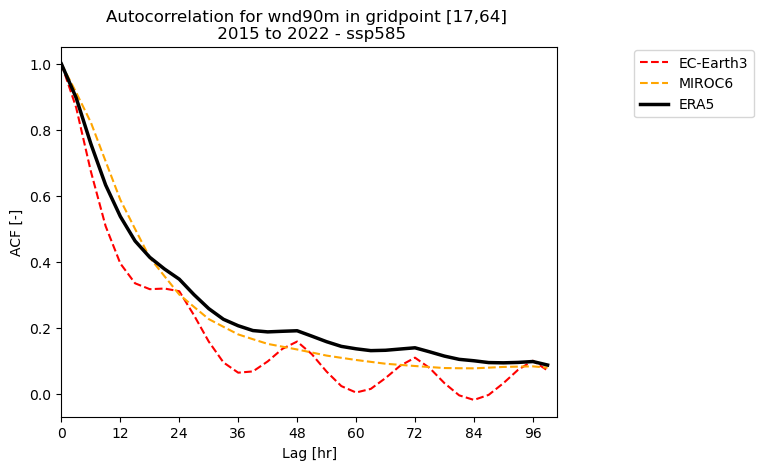

In [36]:
grid_coords = [17,64]
variable = "wnd90m"
era5 = 'yes'            #Compare with era5?
# era5 = None

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    lags = 100
else: 
    CMIP6_models = CMIP6_models_solar
    lags = 50

ssp_variant = 'ssp585'
yy_start = 15
yy_end = 22
# dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"
    
figname = None
# figname = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Autocorrelation\\autocorrelation_{variable}_CMIP6_ERA5_{grid_info}.png"

# create a list with the data
data =[f'Corrected_Europe_EC_Earth3_ssp585_15_22_wnd90m',
       f'Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix']

autocorrelation(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05,era5=era5,figname=figname)
plt.show()

Plotting ERA5 for the historical period


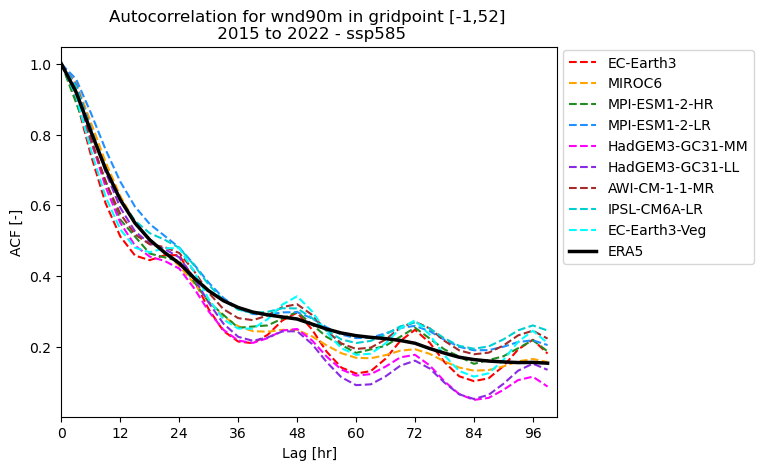

In [37]:
grid_coords = [-1,52]
variable = "wnd90m"
era5 = 'yes'            #Compare with era5?
# era5 = None

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    lags = 100
else: 
    CMIP6_models = CMIP6_models_solar
    lags = 50

ssp_variant = 'ssp585'
yy_start = 15
yy_end = 22
# dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"
    
figname = None
# figname = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Autocorrelation\\autocorrelation_{variable}_CMIP6_ERA5_{grid_info}.png"

# create a list with the data
data =[]
for CMIP6_model in CMIP6_models: 
    CMIP6_model = CMIP6_model.replace("-","_")
    for ssp_variant in ssp_variants:
        cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
        data_name = f'{cutout_name}_{variable}'
        data.append(data_name)

autocorrelation(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05,era5=era5,figname=figname)
plt.show()

### BOC influx

Plotting ERA5 for the historical period


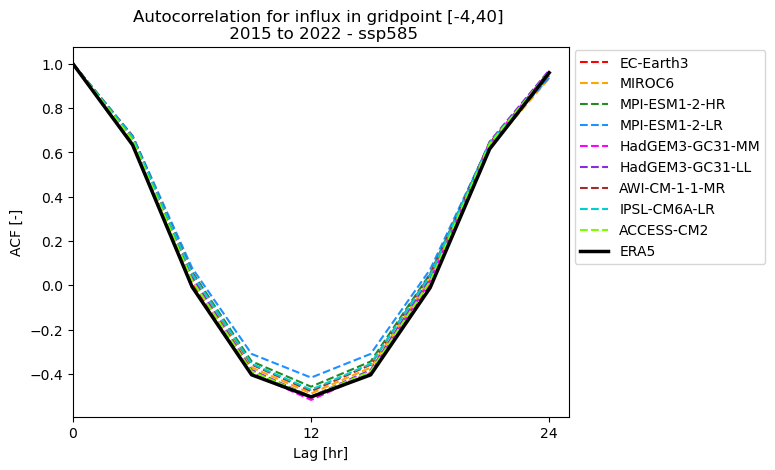

In [38]:
grid_coords = [-4,40]
variable = "influx"
era5 = 'yes'            #Compare with era5?
# era5 = None

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    lags = 100
else: 
    CMIP6_models = CMIP6_models_solar
    lags = 24

ssp_variant = 'ssp585'
yy_start = 15
yy_end = 22
# dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"
    
figname = None
# figname = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Autocorrelation\\autocorrelation_{variable}_CMIP6_ERA5_{grid_info}.png"

# create a list with the data
data =[]
for CMIP6_model in CMIP6_models: 
    CMIP6_model = CMIP6_model.replace("-","_")
    for ssp_variant in ssp_variants:
        cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
        data_name = f'{cutout_name}_{variable}'
        data.append(data_name)

autocorrelation(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05,era5=era5,figname=figname)
plt.show()

### EOC - WIND

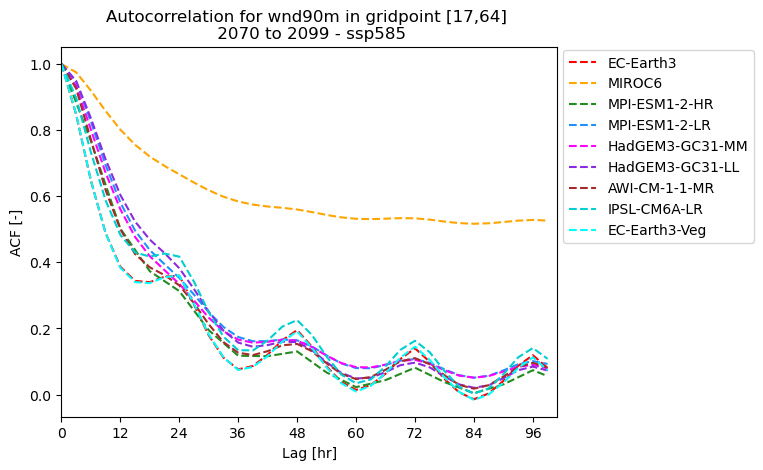

In [39]:
grid_coords = [17,64]
variable = "wnd90m"
# era5 = 'yes'            #Compare with era5?
era5 = None

if variable =="wnd90m":
    CMIP6_models = CMIP6_models_wind
    lags = 100
else: 
    CMIP6_models = CMIP6_models_solar
    lags = 50

ssp_variant = 'ssp585'
yy_start = 70
yy_end = 99
# dx = 100        #[km] Resolution of cutout

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"
    
figname = None
# figname = f"C:\\Users\Theag\OneDrive - Aarhus Universitet\Master Project - shared folder\Figures\BOC\Autocorrelation\\autocorrelation_{variable}_CMIP6_ERA5_{grid_info}.png"

# create a list with the data
data =[]
for CMIP6_model in CMIP6_models: 
    CMIP6_model = CMIP6_model.replace("-","_")
    for ssp_variant in ssp_variants:
        cutout_name = f'Corrected_Europe_{CMIP6_model}_{ssp_variant}_{yy_start}_{yy_end}'
        data_name = f'{cutout_name}_{variable}'
        data.append(data_name)

autocorrelation(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05,era5=era5,figname=figname)
plt.show()

## BOC autocorrelation in all points for all models

(NB: This utilizes the BOC_vs_EOC function which is a couple of cells below - this plot is here because it is ONLY for BOC, no comparison to EOC.)

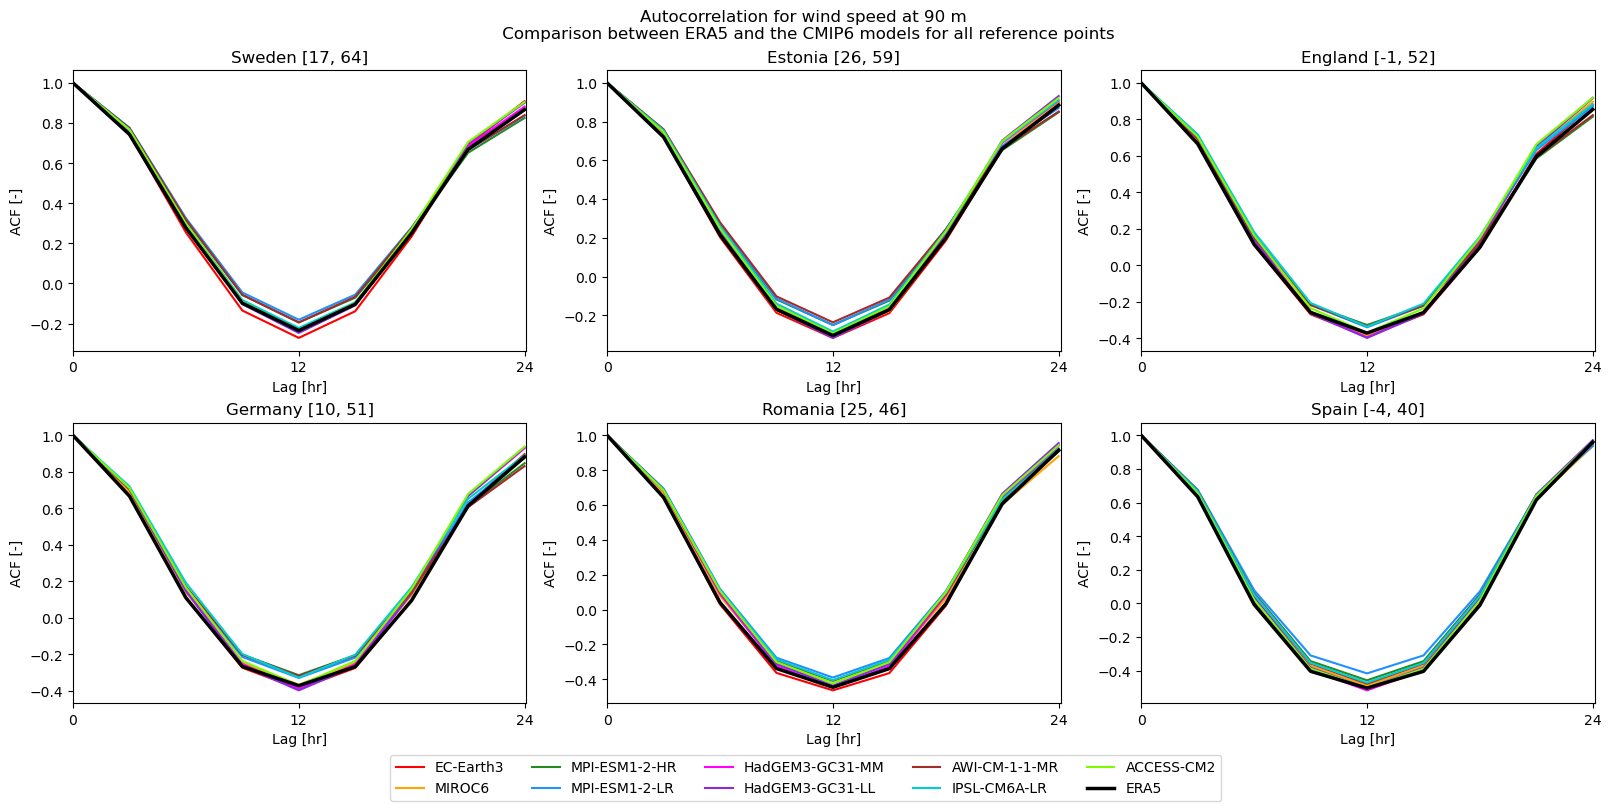

In [43]:
### INFLUX ########
variable = "wnd90m"
CMIP6_models = CMIP6_models_wind

variable = "influx"
CMIP6_models = CMIP6_models_solar

point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

legend_mod = False;
ssp_variant = 'ssp585'
fig,axs = plt.subplots(2,3,figsize=(16,8),layout='constrained')
title = f'Autocorrelation for wind speed at 90 m \n Comparison between ERA5 and the CMIP6 models for all reference points'
fig.suptitle(title)
plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']

legend = []
for ii in range(6):
    legend = []
    point_name = f'point_{ii+1}';
    point = locals()[point_name];
    country_name = ref_country[ii]
    
    for CMIP6_model in CMIP6_models:
        plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']
        
        if ii == 5:
            legend.append(CMIP6_model)
        
        #####
        grid_coords = [point[0],point[1]]
        ssp_variant = 'ssp585'

        data_BOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_15_22_{variable}"]
        
        if variable =="wnd90m":
            lags = 100
        else: 
            lags = 24

        (acf_x_BOC, x_axis_BOC)=autocorrelation_BOC_vs_EOC(data_BOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
        axs.flat[ii].plot(x_axis_BOC,acf_x_BOC,c = plotcolor,linestyle='-')
    
    
    if variable == "wnd90m": 
        data_era5 = Europe_era5_15_22_wnd90m_3hr_corrected.sel(x=point[0],y=point[1])
    else: 
        data_era5 = Europe_era5_15_22_influx_3hr.sel(x=point[0],y=point[1])
    
    data_era5 = data_era5.where(data_era5.isnull()==False,0.0)
    
    nlags = round(lags/3)
    alpha = 0.05
    
    acf_era5 = acf(
            data_era5,
            nlags=nlags,
            alpha=alpha,
            fft=False,
            bartlett_confint=True,
            adjusted=False,
            missing='none',
        )
    if alpha is not None:
            acf_era5, confint = acf_era5[:2]
        
    axs.flat[ii].plot(x_axis_BOC,acf_era5,'black',linewidth=2.5)
    legend.append('ERA5')
    
    
    # axs.flat[ii].legend(legend)
    axs.flat[ii].set_xlim([0, lags+0.1])
    axs.flat[ii].set_xticks(np.arange(0,lags+1,12))
    axs.flat[ii].set_ylabel('ACF [-]')
    axs.flat[ii].set(xlabel='Lag [hr]')
    axs.flat[ii].set_title(f'{country_name} [{point[0]}, {point[1]}]')

fig.legend(legend,ncols=5,loc='outside lower center')

In [82]:
# Save plot above?
filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/BOC/Autocorrelation/ACF_{variable}_all_models_all_refpoints.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

'C://Users/Theag/OneDrive - Aarhus Universitet\\Master Project - shared folder/Figures/BOC/Autocorrelation/ACF_influx_all_models_all_refpoints.png'

#### EOC Autocorrelation - comparing the same models for BOC and EOC
Making new function, only for comparison between the same model(s)

In [42]:
def autocorrelation_BOC_vs_EOC(data,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05):
    # CMIP6_models = CMIP6_models*2
    if grid_coords[0] > globals()[data[0]][0,-1,-1].x.values or grid_coords[1] > globals()[data[0]][0,-1,-1].y.values:
        print('Grid coords not in cutout')
        
    elif grid_coords[0] < globals()[data[0]][0,0,0].x.values or grid_coords[1] < globals()[data[0]][0,0,0].y.values:
        print('Grid coords are not in cutout!')
        data = []       #Lazy way to make function fail. Sorry. 
    
    #Converting grid_coords to cell_coords
    cell_coords = [grid_coords[1] - globals()[data[0]][0,0,0].y.values, grid_coords[0] - globals()[data[0]][0,0,0].x.values]
    nlags = round(lags/3)        #Number of lags from hourly to 3-hourly values
    
    for i in range(len(data)):
        data_i = data[i]
        
        if data_i == 'Corrected_Europe_MPI_ESM1_2_HR_ssp585_15_22_wnd90m' or data_i == 'Corrected_Europe_MPI_ESM1_2_HR_ssp585_70_99_wnd90m' or data_i == 'Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix': 
            # data_i = globals()[data_i][cell_coords[0],cell_coords[1],:]
            data_i = globals()[data_i].sel(x=grid_coords[0],y=grid_coords[1])
            
        else: 
            data_i = globals()[data_i][:,cell_coords[0],cell_coords[1]]
        
        if np.any(data_i.isnull()) == True:
            data_i = data_i.dropna(dim="time",how="all")
        
        acf_x = acf(
            data_i,
            nlags=nlags,
            alpha=alpha,
            fft=False,
            bartlett_confint=True,
            adjusted=False,
            missing='none',
        )
        if alpha is not None:
            acf_x, confint = acf_x[:2]
        
        x_axis = np.linspace(0,len(acf_x)-1,len(acf_x))*3           #Only intended for values at 3-hourly frequency
    
        
    return acf_x, x_axis

### One model all locations

In [23]:
CMIP6_models_solar[0]

'EC-Earth3'

'C://Users/Theag/OneDrive - Aarhus Universitet\\Master Project - shared folder/Figures/EOC/ACF/ACF_influx_ACCESS_CM2_all_refpoints.png'

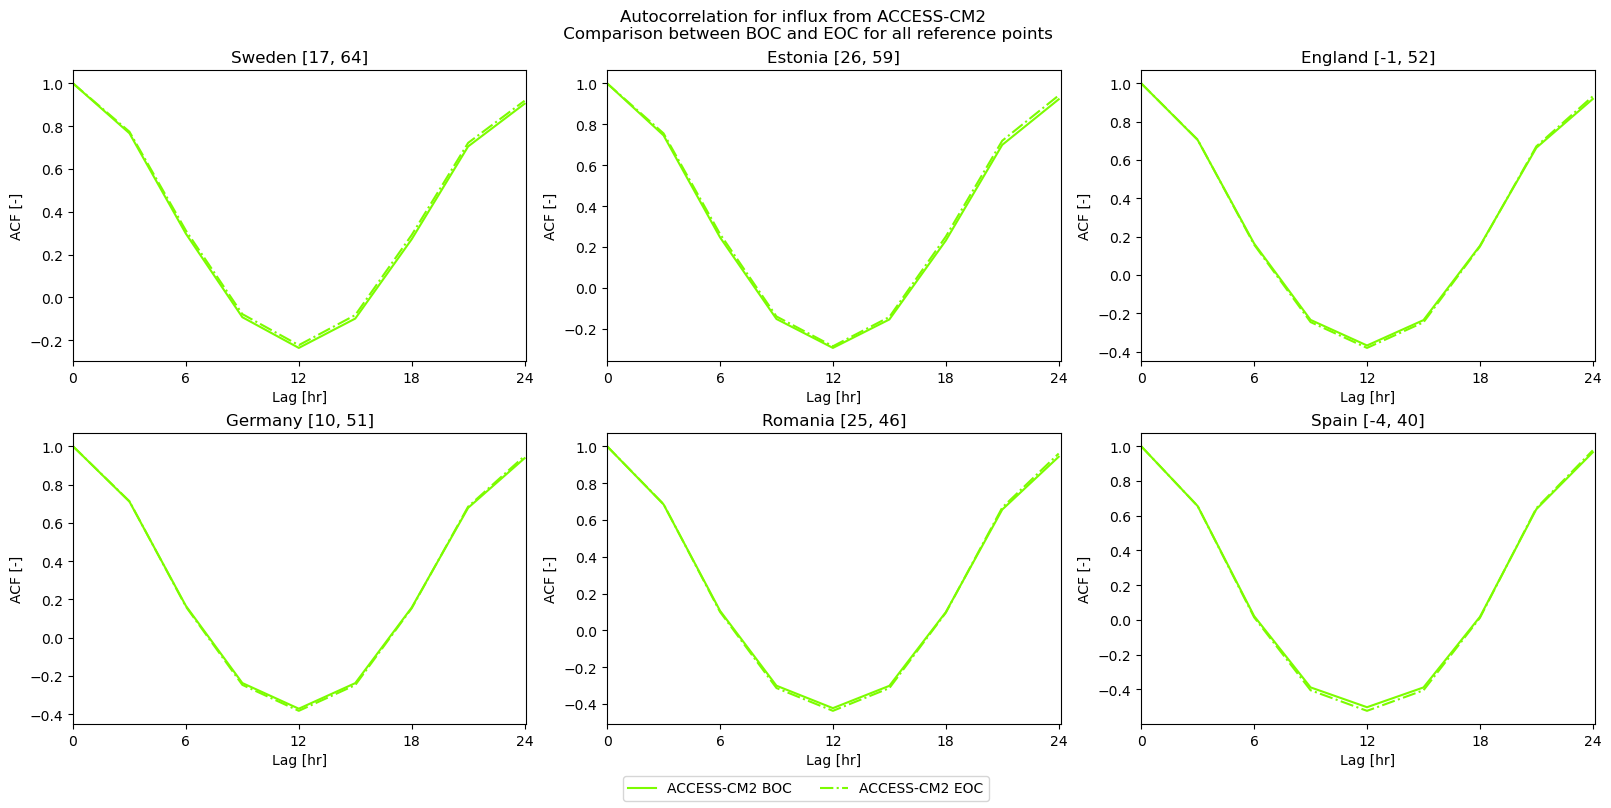

In [48]:
### INFLUX ########
variable = "influx"
CMIP6_model = CMIP6_models_solar[8]
CMIP6_models = [CMIP6_model,CMIP6_model]
bins = 30

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

legend_mod = False;
ssp_variant = 'ssp585'
fig,axs = plt.subplots(2,3,figsize=(16,8),layout='constrained')
title = f'Autocorrelation for influx from {CMIP6_model} \n Comparison between BOC and EOC for all reference points'
fig.suptitle(title)
plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']

for ii in range(6):
    legend = []
    point_name = f'point_{ii+1}';
    point = locals()[point_name];
    country_name = ref_country[ii]
    # CMIP6_model =CMIP6_model.replace('-','_')
    plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']
    
    #####
    grid_coords = [point[0],point[1]]
    era5 = None
    ssp_variant = 'ssp585'

    data_BOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_15_22_{variable}"]
    data_EOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_70_99_{variable}"]
    
    if variable =="wnd90m":
        lags = 100
    else: 
        lags = 24

    (acf_x_BOC, x_axis_BOC)=autocorrelation_BOC_vs_EOC(data_BOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    (acf_x_EOC, x_axis_EOC)=autocorrelation_BOC_vs_EOC(data_EOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    axs.flat[ii].plot(x_axis_BOC,acf_x_BOC,c = plotcolor,linestyle='-')
    axs.flat[ii].plot(x_axis_EOC,acf_x_EOC,c = plotcolor,linestyle='-.')

    
    # axs.flat[ii].legend(legend)
    axs.flat[ii].set_xlim([0, lags+0.1])
    axs.flat[ii].set_xticks(np.arange(0,lags+1,6))
    axs.flat[ii].set_ylabel('ACF [-]')
    axs.flat[ii].set(xlabel='Lag [hr]')
    axs.flat[ii].set_title(f'{country_name} [{point[0]}, {point[1]}]')

fig.legend([f"{CMIP6_model.replace('_','-')} BOC",f"{CMIP6_model.replace('_','-')} EOC"],ncols=2,loc='outside lower center')

# Save plot above?
filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/EOC/ACF/ACF_{variable}_{CMIP6_model.replace('-','_')}_all_refpoints.png"
# fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

In [56]:
# Save plot above?
filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/EOC/ACF/ACF_{variable}_{CMIP6_model.replace('-','_')}_all_refpoints.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

'C://Users/Theag/OneDrive - Aarhus Universitet\\Master Project - shared folder/Figures/EOC/ACF/ACF_influx_MPI_ESM1_2_LR_all_refpoints.png'

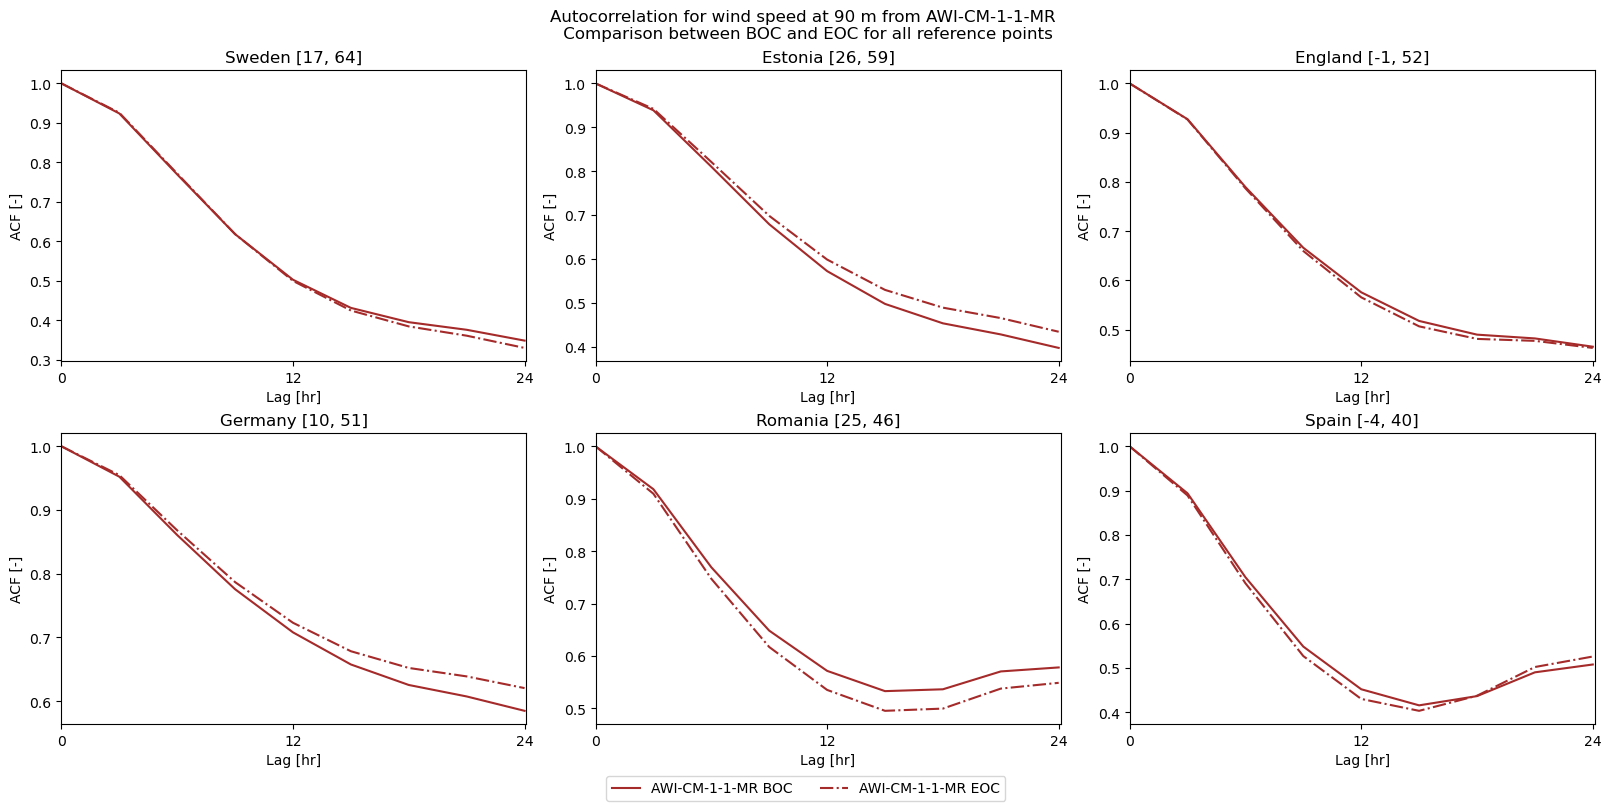

In [49]:
### wind speed ########
variable = "wnd90m"
CMIP6_model = CMIP6_models_wind[6]
CMIP6_models = [CMIP6_model,CMIP6_model]
bins = 30

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

legend_mod = False;
ssp_variant = 'ssp585'
fig,axs = plt.subplots(2,3,figsize=(16,8),layout='constrained')
title = f'Autocorrelation for wind speed at 90 m from {CMIP6_model} \n Comparison between BOC and EOC for all reference points'
fig.suptitle(title)
plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']

for ii in range(6):
    legend = []
    point_name = f'point_{ii+1}';
    point = locals()[point_name];
    country_name = ref_country[ii]
    # CMIP6_model =CMIP6_model.replace('-','_')
    plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']
    
    #####
    grid_coords = [point[0],point[1]]
    era5 = None
    ssp_variant = 'ssp585'

    data_BOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_15_22_{variable}"]
    data_EOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_70_99_{variable}"]
    
    if variable =="wnd90m":
        lags = 24
    else: 
        lags = 24

    (acf_x_BOC, x_axis_BOC)=autocorrelation_BOC_vs_EOC(data_BOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    (acf_x_EOC, x_axis_EOC)=autocorrelation_BOC_vs_EOC(data_EOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    axs.flat[ii].plot(x_axis_BOC,acf_x_BOC,c = plotcolor,linestyle='-')
    axs.flat[ii].plot(x_axis_EOC,acf_x_EOC,c = plotcolor,linestyle='-.')

    
    # axs.flat[ii].legend(legend)
    axs.flat[ii].set_xlim([0, lags+0.1])
    axs.flat[ii].set_xticks(np.arange(0,lags+1,12))
    axs.flat[ii].set_ylabel('ACF [-]')
    axs.flat[ii].set(xlabel='Lag [hr]')
    axs.flat[ii].set_title(f'{country_name} [{point[0]}, {point[1]}]')

fig.legend([f"{CMIP6_model.replace('_','-')} BOC",f"{CMIP6_model.replace('_','-')} EOC"],ncols=2,loc='outside lower center')

# # Save plot above?
# filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/EOC/ACF/ACF_{variable}_{CMIP6_model.replace('-','_')}_all_refpoints.png"
# fig.savefig(filepath,dpi=300,bbox_inches='tight')
# filepath

In [63]:
# Save plot above?
filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/EOC/ACF/ACF_{variable}_{CMIP6_model.replace('-','_')}_all_refpoints.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

'C://Users/Theag/OneDrive - Aarhus Universitet\\Master Project - shared folder/Figures/EOC/ACF/ACF_wnd90m_EC_Earth3_all_refpoints.png'

# EC-Earth3 - method 2 vs method 3

Grid coords not in cutout
Grid coords not in cutout
Grid coords not in cutout
Grid coords not in cutout
Grid coords not in cutout
Grid coords not in cutout


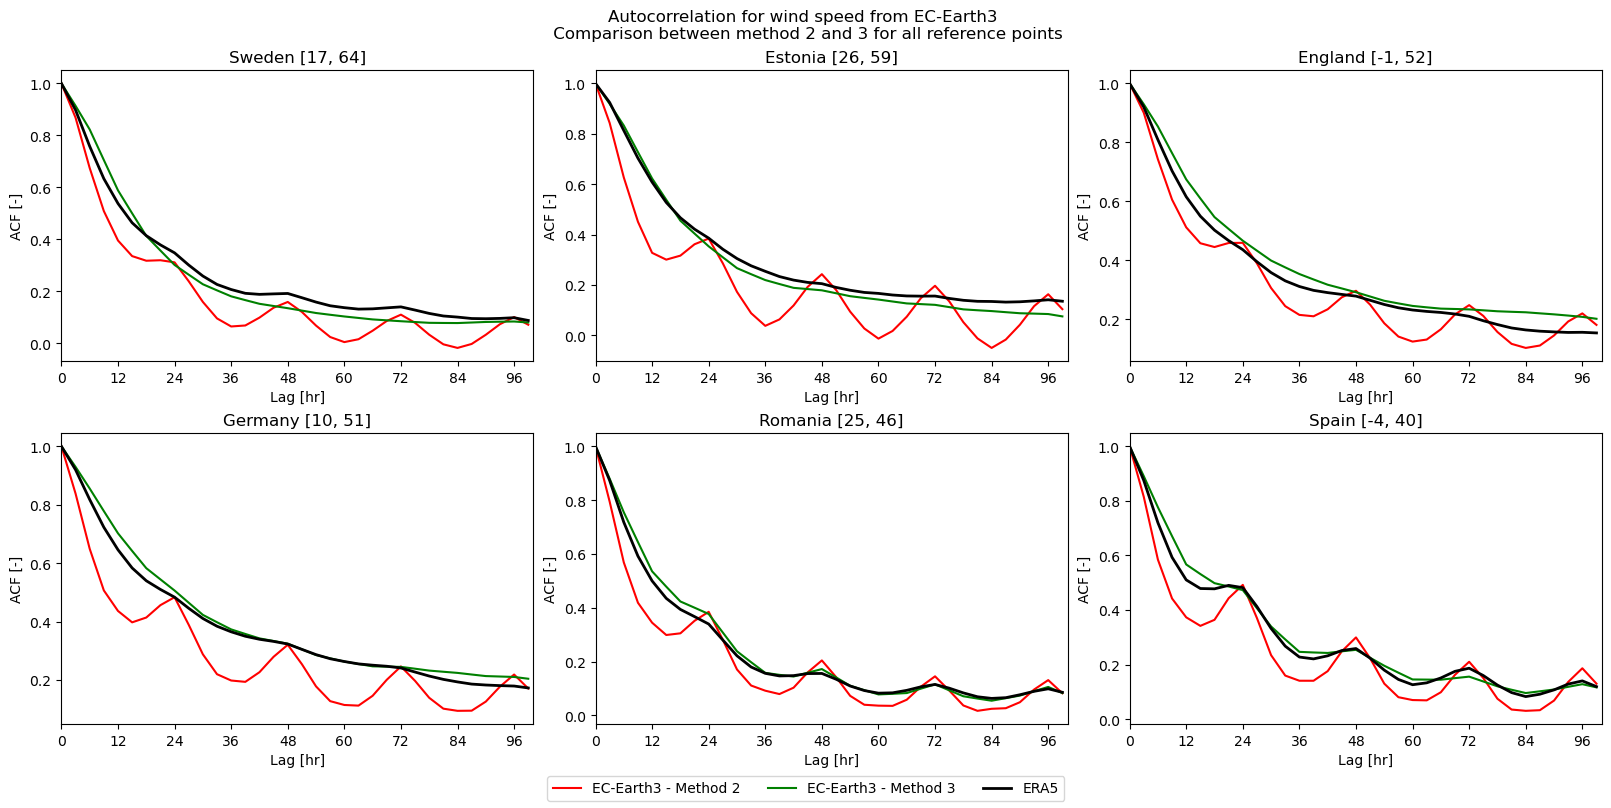

In [50]:
### INFLUX ########
variable = "wnd90m"
CMIP6_model = 'EC-Earth3'
CMIP6_models = [CMIP6_model,CMIP6_model]
bins = 30

if grid_coords[0] < 0: 
    grid_info = f"xneg{abs(grid_coords[0])}_y{grid_coords[1]}"
else:
    grid_info = f"x{grid_coords[0]}_y{grid_coords[1]}"

point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

legend_mod = False;
ssp_variant = 'ssp585'
fig,axs = plt.subplots(2,3,figsize=(16,8),layout='constrained')
title = f'Autocorrelation for wind speed from {CMIP6_model} \n Comparison between method 2 and 3 for all reference points'
fig.suptitle(title)
plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']

for ii in range(6):
    legend = []
    point_name = f'point_{ii+1}';
    point = locals()[point_name];
    country_name = ref_country[ii]
    # CMIP6_model =CMIP6_model.replace('-','_')
    plotcolor = model_colors.loc[CMIP6_model.replace('_','-')]['Color']
    
    #####
    grid_coords = [point[0],point[1]]
    era5 = None
    ssp_variant = 'ssp585'

    data_BOC = [f"Corrected_Europe_{CMIP6_model.replace('-','_')}_{ssp_variant}_15_22_{variable}"]
    data_method3 = [f"Europe_EC_Earth3_ssp585_15_22_wnd90m_power_law_GWA_corrected_no_indicator_matrix"]
    data_era5 = [f'Europe_era5_15_22_wnd90m_3hr_corrected']

    if variable =="wnd90m":
        lags = 100
    else: 
        lags = 24

    (acf_x_BOC, x_axis_BOC)=autocorrelation_BOC_vs_EOC(data_BOC,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    (acf_x_method3, x_axis_method3)=autocorrelation_BOC_vs_EOC(data_method3,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)
    (acf_x_era5, x_axis_era5)=autocorrelation_BOC_vs_EOC(data_era5,lags,grid_coords,CMIP6_models,ssp_variants,variable,alpha=0.05)

    axs.flat[ii].plot(x_axis_BOC,acf_x_BOC,c = plotcolor,linestyle='-')
    axs.flat[ii].plot(x_axis_method3,acf_x_method3,c = 'green',linestyle='-')
    axs.flat[ii].plot(x_axis_era5,acf_x_era5,c = 'black',linestyle='-',linewidth=2)

    
    # axs.flat[ii].legend(legend)
    axs.flat[ii].set_xlim([0, lags+0.1])
    axs.flat[ii].set_xticks(np.arange(0,lags+1,12))
    axs.flat[ii].set_ylabel('ACF [-]')
    axs.flat[ii].set(xlabel='Lag [hr]')
    axs.flat[ii].set_title(f'{country_name} [{point[0]}, {point[1]}]')

fig.legend([f"{CMIP6_model.replace('_','-')} - Method 2",f"{CMIP6_model.replace('_','-')} - Method 3",'ERA5'],ncols=3,loc='outside lower center')

In [52]:

# Save plot above?
filepath = f"C://Users/Theag/OneDrive - Aarhus Universitet\Master Project - shared folder/Figures/BOC/Autocorrelation/ACF_{variable}_EC_Earth3_meth2_vs_meth3_all_refpoints.png"
fig.savefig(filepath,dpi=300,bbox_inches='tight')
filepath

'C://Users/Theag/OneDrive - Aarhus Universitet\\Master Project - shared folder/Figures/BOC/Autocorrelation/ACF_wnd90m_EC_Earth3_meth2_vs_meth3_all_refpoints.png'

## Plotting the ACF for wind10m for ERA5 to investigate the daily fluctuation

In [51]:
import glob
path = "E://Master's/ERA5/wnd10m/wnd10m_tot/"
ERA5_filepaths_wnd10m = glob.glob(path+'*.nc')

ERA5_filepaths_wnd10m

path = "E://Master's/ERA5/wnd10m/wnd10m_tot\\"
for filename in ERA5_filepaths_wnd10m:
    variablename = filename.replace(path,"").replace('.nc','')
    print(variablename)
    locals()[variablename] = xr.open_dataarray(filename)
    
Europe_era5_15_22_wnd10m = xr.concat((Europe_era5_15_wnd10m,
                                      Europe_era5_16_wnd10m,
                                      Europe_era5_17_wnd10m,
                                      Europe_era5_18_wnd10m,
                                      Europe_era5_19_wnd10m,
                                      Europe_era5_20_wnd10m,
                                      Europe_era5_21_wnd10m,
                                      Europe_era5_22_wnd10m),dim="time")

Europe_era5_15_wnd10m
Europe_era5_18_wnd10m
Europe_era5_19_wnd10m
Europe_era5_21_wnd10m
Europe_era5_22_wnd10m
Europe_era5_16_wnd10m
Europe_era5_17_wnd10m
Europe_era5_20_wnd10m


In [52]:
point_1 = (17,64)
point_2 = (26,59)
point_3 = (-1,52)
point_4 = (10,51)
point_5 = (25,46)
point_6 = (-4,40)

ref_country = ['Sweden', 'Estonia', 'England', 'Germany', 'Romania', 'Spain']

i = 2
point = locals()[f"point_{i}"]
country = ref_country[i]
data_era5_10m = Europe_era5_15_22_wnd10m.sel(x=point[0],y=point[1])
lags = 100
nlags = round(lags/3) 
alpha = 0.05

Text(0, 0.5, 'ACF [-]')

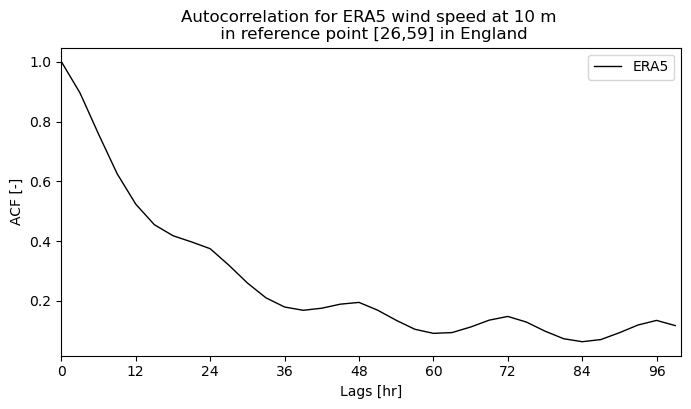

In [53]:
acf_era5_10m = acf(
            data_era5_10m,
            nlags=nlags,
            alpha=alpha,
            fft=False,
            bartlett_confint=True,
            adjusted=False,
            missing='none',
        )
if alpha is not None:
    acf_era5_10m, confint = acf_era5_10m[:2]

x_axis = np.linspace(0,len(acf_era5_10m)-1,len(acf_era5_10m))*3  

plt.figure(figsize=(8,4))
plt.plot(x_axis,acf_era5_10m,'black',linewidth=1)
plt.title(f'Autocorrelation for ERA5 wind speed at 10 m \n in reference point [{point[0]},{point[1]}] in {country}')
plt.legend(['ERA5'])
plt.xlim([0, lags])
plt.xticks(np.arange(0,lags+1,12))
plt.xlabel('Lags [hr]')
plt.ylabel('ACF [-]')